#  Project Title: Sarcopenia and Stability: Reinforcement Learning Insights into Elderly Balance through MyoSuite

**Name: Huiyi Wang** <br>
**McGill ID: 261016753**

**Motivation**: <br>
Preventing falls and maintaining stability are critical components of elderly care as more than 30% of the population in Canada of age 60+ experience falling (https://www.canada.ca/en/public-health/services/publications/healthy-living/surveillance-report-falls-older-adults-canada.html). This importance is underscored by the onset of sarcopenia in the lower extremities, a condition characterized by age-related muscle loss that can increase the likelihood of falls. This project aims to analyze the impact of sarcopenia on an individual's ability to remain stable while standing (double stance) by utilizing the advanced simulator within **MyoSuite** which integrates reinforcement learning within a forward-dynamic musculoskeletal simulator. 

The coordination of muscle groups is highly over-determined, making an optimization method to learn human motions extremely hard. Hence, reinforcement learning is preferred in this scenario so that the movement and activation does not exhibit a direct causal relationship but is a simple reward-action environment.

**Simulator**: We will be using MyoSuite, a contact-rich framework for musculoskeletal motor control. Within the simulator, we will be using the **MyoLeg** repository, which has 20 degrees of freedom, 80 actuators, and 60 biological muscles. The simulator also allows for a sarcopenia condition by decreasing 50% of model musle. More can be found at: https://arxiv.org/abs/2205.13600 and https://myosuite.readthedocs.io/en/latest/

MyoSuite allows the integration between forward musculoskeletal simulation forward dynamics and reinforcement learning. The state space would be modelled by $\mathcal{S} = \{l^{MT}, v^{MT}\}$ where $l^{MT}$ and $v^{MT}$ is the muscle-tendon length and muscle-tendon velocity the action within the system is only the muscle activation of the 80 actuators, $\mathcal{A} = a_i(t), \quad 1 \leq i \leq 80$, the we would define reward later.

**Algorithm**:
We choose to employ proximal policy graident (PPO) that uses a Clipped Objective to control the gradient change of policy from each step. We will also be implementing deep learning by passing two Neural Network (NN), one for the policy and one for the value function. The NN has two deep layers with 64 neurons each. 

We define our reward function to be:

$$\mathcal{R} = w_e \cdot r_e - w_m \cdot r_m +  w_c \cdot r_c$$

where $\{w_e, w_r, w_c \} $ is the weight for each reward. $r_e$ is the position error of the pelvis from the pre-defined key position, $r_m$ is the metabolic cost of the agent given by $r_m = \frac{1}{N_{\rm mus}} \sum a^2_i$, $r_c$ is whether the x, y coordinate of the agent's center of mass (COM) is within the base of support (BoS). 

**Methology**:
We will train the agent in a custom gym environment build by MyoSuite under both a normal subject and a sarcopenia subject. We would apploy a perturbation within the anterior-posterior (AP) direction and mediolateral (ML) position between 1 to 50 N at random.  *The agent is say to complete the stability task if it can maintain its COM within the base of support (BoS) after 1000 steps during evaluation.*

We plan to implement PPO through stablebaseine3 (https://stable-baselines3.readthedocs.io/en/master/index.html). We will first train the agent to stand under perturbation under a healthy circumstance. Then we will apply curriculum learning at a sarcopenia condition to see how the muscle activation transfer between those scenario. 

**Project Goal:** Can reinforcement learning be used to reproduce motions of human standing balance under sarcopenia condition?

**Hypothesis:**  We proposed that under sarcopenia condition, baseline stability pollicy would lead to higher falling rates and shorter standing time under perturbation than in healthy (reference) subject.

## Part 1: Training the Agent

Here we provide the training algorithm, which requires roughly 21 hours. This would likely have too much dependency. You can skip ahead and run the pkl files in Part 4 which contains compiled joint, muscle, center of mass (COM) information, etc. from running 200 episodes in healthy and sarcopenia subject with the final policy trained. 


If attempt to run the custom gym environment in Jupyter on your own computer, please proceed with the following installation.

1. Python 3.8
2. mujoco-py
3. gym
4. custom environment
5. stable_baselines3

In [7]:
!pip install python
!pip install mujoco-py
!pip install gym
!git clone --recursive https://github.com/cherylwang20/MyoLeg_Sarcopenia.git
#cd mj_envs
!pip install -e .
!pip install stable-baselines3

ERROR: Could not find a version that satisfies the requirement python (from versions: none)
ERROR: No matching distribution found for python
Cloning into 'MyoLeg_Sarcopenia'...
Updating files:  99% (226/227)
Updating files: 100% (227/227)
Updating files: 100% (227/227), done.
Submodule 'mj_envs' (git@github.com:cherylwang20/mj_envs.git) registered for path 'mj_envs'
Cloning into 'C:/Users/chery/Documents/MyoLeg_Sarcopenia/MyoLeg_Sarcopenia/mj_envs'...
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
fatal: clone of 'git@github.com:cherylwang20/mj_envs.git' into submodule path 'C:/Users/chery/Documents/MyoLeg_Sarcopenia/MyoLeg_Sarcopenia/mj_envs' failed
Failed to clone 'mj_envs'. Retry scheduled
Cloning into 'C:/Users/chery/Documents/MyoLeg_Sarcopenia/MyoLeg_Sarcopenia/mj_envs'...
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repo

  Using cached mujoco_py-2.1.2.14-py3-none-any.whl (2.4 MB)
     ---------------------------------------- 2.8/2.8 MB 19.7 MB/s eta 0:00:00
  Using cached fasteners-0.19-py3-none-any.whl (18 kB)


fatal: destination path 'MyoLeg_Sarcopenia' already exists and is not an empty directory.


Obtaining file:///C:/Users/chery/Documents/MyoLeg_Sarcopenia


ERROR: file:///C:/Users/chery/Documents/MyoLeg_Sarcopenia does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


First run the training with ```sarco = False``` for a reference subject. Then, load the pretrained policy with ```PPO.load``` on sarcopenia environment.

In [ ]:
import gym
from gym import spaces
import mujoco_py
import mj_envs
import numpy as np
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from datetime import datetime
import torch
import time

In [8]:
class TensorboardCallback(BaseCallback):
        """
        Custom callback for plotting additional values in tensorboard.
        """

        def __init__(self, verbose=0):
            super(TensorboardCallback, self).__init__(verbose)

        def _on_step(self) -> bool:
            # Log scalar value (here a random variable)
            value = self.training_env.get_obs_vec()
            self.logger.record("obs", value)

            return True
sarco = False
if sarco:
    env_name = 'myoSarcLegReachFixed-v3'
else:
    env_name = 'myoLegReachFixed-v2'

env = gym.make(f'mj_envs.robohive.envs.myo:{env_name}')

training_steps = 50000000

print('Begin training')
print(env_name)

start_time = time.time()
time_now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
print(time_now + '\n\n')
if sarco:
        log_path = './standingBalance-sarco/policy_best_model/'+ env_name + '/' + time_now +'/'
else:
        log_path = './standingBalance/policy_best_model/'+ env_name + '/' + time_now +'/'


print(env.rwd_keys_wt) 
print(env.obs_dict.keys())
eval_callback = EvalCallback(env, best_model_save_path=log_path, log_path=log_path, eval_freq=10000, deterministic=True, render=False)
print('max episode steps: ', env._max_episode_steps) 
policy_kwargs = dict(activation_fn=torch.nn.Sigmoid, net_arch=(dict(pi=[64, 64], vf=[64, 64])))
if sarco:
    #if under sarcopenia condition, we use curriculum learning
    #and load a pretrained policy from healthy condition to speed up the training process
    model = PPO.load('standingBalance/policy_best_model/myoLegReachFixed-v2/2023_11_22_17_43_32/best_model',  env, verbose=0, policy_kwargs=policy_kwargs, tensorboard_log="./standingBalance-sarco/temp_env_tensorboard/"+env_name)
else:
     model = PPO('MlpPolicy', env, verbose=0, policy_kwargs =policy_kwargs, tensorboard_log="C:/Users/chery/Documents/MyoLeg_Sarcopenia/StandingBalance/temp_env_tensorboard/"+env_name)

obs_callback = TensorboardCallback()

callback = CallbackList([obs_callback, eval_callback])

model.learn(total_timesteps= training_steps, tb_log_name=env_name+"_" + time_now, callback=eval_callback)
model.save('ep_train_results')
elapsed_time = time.time() - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(time_now)
print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds.")


You appear to be missing MuJoCo.  We expected to find the file here: C:\Users\chery\.mujoco\mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html



Exception: 
You appear to be missing MuJoCo.  We expected to find the file here: C:\Users\chery\.mujoco\mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html


### Part 1.1: Hyperparameter Tunning
The hyperparameter tunable in this environment is the weights, $w$, assigned to each of the reward, the number of episodes trained, the capacity of the deep NN implemented. 

We kept the deep NN to have two deep layers with 64 neurons each. The final parameter tunned is: $w_e = 2$, $w_m = 1$, $w_c = 1$ for reference model and $w_e = 2$, $w_m = 0.5$, $w_c = 1$.

### Part 1.2 TensorBoard
Here, we show the tensorboard training log of the two agents to demonstrate convergence of the model. The reward is different as we have changed the weights of the reward during different runs of training.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('.\myoLegReachFixed-v2_2023_11_22_17_43_32_reward.csv')
df_sarc = pd.read_csv('.\csv_sarco.csv')

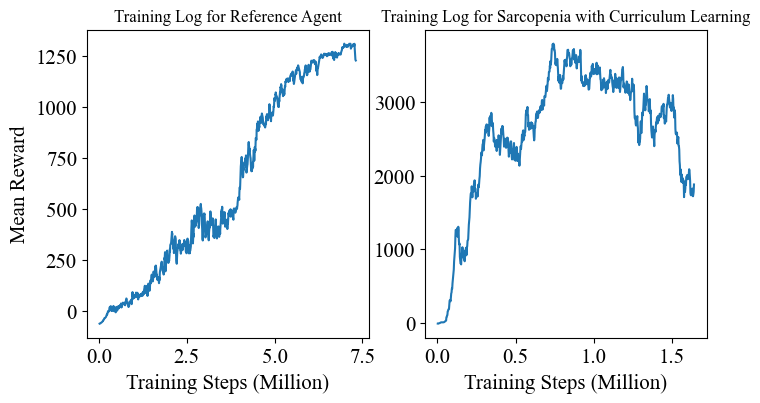

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(df['Step']/1e6, df['Reward'])
#plt.plot(df['Step']/1e6, df['Episode_Length'])
plt.xlabel('Training Steps (Million)')
plt.ylabel('Mean Reward')
plt.title('Training Log for Reference Agent', fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(df_sarc['Step']/1e6, df_sarc['Value'])
#plt.plot(df['Step']/1e6, df['Episode_Length'])
plt.xlabel('Training Steps (Million)')
plt.title('Training Log for Sarcopenia with Curriculum Learning', fontsize = 12)
plt.show()

## Part 2.1: Evaluating the Trained Policy

We evaluate the trained policies on both reference and sarcopenia condition to calculate the overall reward and render a video of it. Since this also involves loading the environment, you can skip ahead to Part 2.2 and see the videos directly.

In [ ]:
import matplotlib.pyplot as plt
import skvideo
#skvideo.setFFmpegPath(r"C:\ffmpeg\bin")
#skvideo.setFFmpegPath(r'C:\users\chery\appdata\local\packages\pythonsoftwarefoundation.python.3.8_qbz5n2kfra8p0\localcache\local-packages\python38\site-packages\ffmpeg')
import skvideo.io
import os
import random
from tqdm.auto import tqdm

In [9]:
nb_seed = 1

sarco = False
movie = True

#load current directory
path = './'

## change the model_num here to the one desired
## reference: '2023_11_22_17_43_32'
## sarco: '2023_12_04_18_29_11'
model_num = '2023_11_22_17_43_32'
if sarco:
    env_name = 'myoSarcLegReachFixed-v3'
    model = PPO.load(path+'/standingBalance-sarco/policy_best_model'+ '/'+ env_name + '/' + model_num +
                  r'/best_model')
    env = gym.make(f'mj_envs.robohive.envs.myo:{env_name}')
else:
    env_name = 'myoLegReachFixed-v2'
    model = PPO.load(path+'/standingBalance/policy_best_model'+ '/'+ env_name + '/' + model_num +
                  r'/best_model')
    env = gym.make(f'mj_envs.robohive.envs.myo:{env_name}')

s, m = [], []

env.reset()

random.seed() 

frames = []
for _ in tqdm(range(3)):
    ep_rewards = []
    done = False
    obs = env.reset()
    for _ in range(250):
        obs = env.obsdict2obsvec(env.obs_dict, env.obs_keys)[1]
        #obs = env.get_obs_dict()
          
        action, _ = model.predict(obs, deterministic=False)
        #env.sim.data.ctrl[:] = action
        obs, reward, done, info = env.step(action)
        m.append(action)
        if movie:
                frame = env.sim.renderer.render_offscreen(width=400, height=400, camera_id=1) 
                frame = np.rot90(np.rot90(frame))
            # if slow see https://github.com/facebookresearch/myosuite/blob/main/setup/README.md
                frames.append(frame[::-1,:,:])
                #env.sim.mj_render(mode='window') # GUI


# evaluate policy
all_rewards = []
for _ in tqdm(range(20)): # 20 random targets
    ep_rewards = []
    done = False
    obs = env.reset()
    step = 0
    while (not done) and (step < 700):
          # get the next action from the policy
          #env.mj_render()
        action, _ = model.predict(obs)
          # take an action based on the current observation
        obs, reward, done, info = env.step(action)
        ep_rewards.append(reward)
        step += 1
    all_rewards.append(np.sum(ep_rewards))
env.close()
print(f"Average reward: {np.mean(all_rewards)} over 20 episodes")


env.close()

if movie:
    if sarco:
        os.makedirs(path+'/videos/sarco' +'/' + env_name, exist_ok=True)
        skvideo.io.vwrite(path+'/videos/sarco'  +'/' + env_name + '/' + model_num + 'video.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})
    else:
        os.makedirs(path+'/videos' +'/' + env_name, exist_ok=True)
        skvideo.io.vwrite(path+'/videos'  +'/' + env_name + '/' + model_num + 'video.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})



You appear to be missing MuJoCo.  We expected to find the file here: C:\Users\chery\.mujoco\mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html



Exception: 
You appear to be missing MuJoCo.  We expected to find the file here: C:\Users\chery\.mujoco\mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html


## Part 2.2: Showing Trained Policy within its environment
We render a video of the policy in the environment from a pre-generated video.

### 2.2.1 Healthy Subject: <br>
Sideview: <br>
<video controls src=".\videos\myoLegReachFixed-v2\2023_11_22_17_43_32video.mp4" />

Frontview: <br>
<video controls src=".\videos\myoLegReachFixed-v2\2023_11_22_17_43_32front_video.mp4" />


### 2.2.2 Sarcopenia Subject: <br>
Sidevide: <br>
<video controls src=".\videos\sarco\myoSarcLegReachFixed-v3\2023_12_04_18_29_11side_video.mp4" />

Frontview: <br>
<video controls src=".\videos\sarco\myoSarcLegReachFixed-v3\2023_12_04_18_29_11video.mp4" />


## Part 3: Running Episodes and Extracting Muscle and Joint Information

We iterate our policy in a non-deterministic environment for 200 episodes in both conditions (```sarco = True``` for sarcopenia environment) with 1000 steps each, with each one applying a perturbation specifies in the Methodology. The results are outputed in pkl files and analyzed in Part 4.

In [ ]:
import matplotlib.pyplot as plt
import skvideo.io
import os
import pickle
import random
from matplotlib.backends.backend_pdf import PdfPages 

from shapely.geometry import Polygon
import matplotlib.pyplot as plt


In [ ]:
def storeData(env, model, steps, env_name, file_name):
    body_names = ['calcn_l', 'calcn_r', 'femur_l', 'femur_r', 'patella_l', 'patella_r', 
                                            'pelvis', 'root', 'talus_l', 'talus_r', 'tibia_l', 'tibia_r', 'toes_l', 'toes_r', 'world']
    joint_names = ['ankle_angle_l', 'ankle_angle_r', 'hip_adduction_l', 'hip_adduction_r', 'hip_flexion_l', 
                                            'hip_flexion_r', 'hip_rotation_l', 'hip_rotation_r', 'knee_angle_l', 'knee_angle_l_beta_rotation1', 
                                            'knee_angle_l_beta_translation1', 'knee_angle_l_beta_translation2', 'knee_angle_l_rotation2', 'knee_angle_l_rotation3', 
                                            'knee_angle_l_translation1', 'knee_angle_l_translation2', 'knee_angle_r', 'knee_angle_r_beta_rotation1', 'knee_angle_r_beta_translation1', 
                                            'knee_angle_r_beta_translation2', 'knee_angle_r_rotation2', 'knee_angle_r_rotation3', 'knee_angle_r_translation1', 'knee_angle_r_translation2', 
                                            'mtp_angle_l', 'mtp_angle_r', 'subtalar_angle_l', 'subtalar_angle_r']
    tendon_names = ['addbrev_l_tendon', 'addbrev_r_tendon', 'addlong_l_tendon', 'addlong_r_tendon', 'addmagDist_l_tendon', 'addmagDist_r_tendon', 'addmagIsch_l_tendon', 'addmagIsch_r_tendon', 'addmagMid_l_tendon', 'addmagMid_r_tendon', 'addmagProx_l_tendon', 'addmagProx_r_tendon', 'bflh_l_tendon', 'bflh_r_tendon', 'bfsh_l_tendon', 'bfsh_r_tendon', 'edl_l_tendon', 'edl_r_tendon', 'ehl_l_tendon', 'ehl_r_tendon', 'fdl_l_tendon', 'fdl_r_tendon', 'fhl_l_tendon', 'fhl_r_tendon', 'gaslat_l_tendon', 'gaslat_r_tendon', 'gasmed_l_tendon', 'gasmed_r_tendon', 'glmax1_l_tendon', 'glmax1_r_tendon', 'glmax2_l_tendon', 'glmax2_r_tendon', 'glmax3_l_tendon', 'glmax3_r_tendon', 'glmed1_l_tendon', 'glmed1_r_tendon', 'glmed2_l_tendon', 'glmed2_r_tendon', 'glmed3_l_tendon', 'glmed3_r_tendon', 'glmin1_l_tendon', 'glmin1_r_tendon', 'glmin2_l_tendon', 'glmin2_r_tendon', 'glmin3_l_tendon', 'glmin3_r_tendon', 'grac_l_tendon', 'grac_r_tendon', 'iliacus_l_tendon', 'iliacus_r_tendon', 'perbrev_l_tendon', 'perbrev_r_tendon', 'perlong_l_tendon', 'perlong_r_tendon', 'piri_l_tendon', 'piri_r_tendon', 'psoas_l_tendon', 'psoas_r_tendon', 'recfem_l_tendon', 'recfem_r_tendon', 'sart_l_tendon', 'sart_r_tendon', 'semimem_l_tendon', 'semimem_r_tendon', 'semiten_l_tendon', 'semiten_r_tendon', 'soleus_l_tendon', 'soleus_r_tendon', 'tfl_l_tendon', 'tfl_r_tendon', 'tibant_l_tendon', 'tibant_r_tendon', 'tibpost_l_tendon', 'tibpost_r_tendon', 'vasint_l_tendon', 'vasint_r_tendon', 'vaslat_l_tendon', 'vaslat_r_tendon', 'vasmed_l_tendon', 'vasmed_r_tendon']
    actuator_names =  ['addbrev_l', 'addbrev_r', 'addlong_l', 'addlong_r', 'addmagDist_l', 'addmagDist_r', 'addmagIsch_l', 
                       'addmagIsch_r', 'addmagMid_l', 'addmagMid_r', 'addmagProx_l', 'addmagProx_r', 'bflh_l', 'bflh_r', 'bfsh_l', 
                       'bfsh_r', 'edl_l', 'edl_r', 'ehl_l', 'ehl_r', 'fdl_l', 'fdl_r', 'fhl_l', 'fhl_r', 'gaslat_l', 'gaslat_r', 
                       'gasmed_l', 'gasmed_r', 'glmax1_l', 'glmax1_r', 'glmax2_l', 'glmax2_r', 'glmax3_l', 'glmax3_r', 'glmed1_l', 
                       'glmed1_r', 'glmed2_l', 'glmed2_r', 'glmed3_l', 'glmed3_r', 'glmin1_l', 'glmin1_r', 'glmin2_l', 'glmin2_r', 
                       'glmin3_l', 'glmin3_r', 'grac_l', 'grac_r', 'iliacus_l', 'iliacus_r', 'perbrev_l', 'perbrev_r', 'perlong_l', 
                       'perlong_r', 'piri_l', 'piri_r', 'psoas_l', 'psoas_r', 'recfem_l', 'recfem_r', 'sart_l', 'sart_r', 'semimem_l', 
                       'semimem_r', 'semiten_l', 'semiten_r', 'soleus_l', 'soleus_r', 'tfl_l', 'tfl_r', 'tibant_l', 'tibant_r', 'tibpost_l', 
                       'tibpost_r', 'vasint_l', 'vasint_r', 'vaslat_l', 'vaslat_r', 'vasmed_l', 'vasmed_r']

    dataStore = {}
    dataStore['modelInfo'] = {}
    dataStore['modelInfo']['bodyNames'] =  body_names
    dataStore['modelInfo']['jointNames'] = joint_names
    dataStore['modelInfo']['tendonNames'] = tendon_names
    dataStore['modelInfo']['rewardWeights'] = env.rwd_keys_wt
    dataStore['modelInfo']['trainingSteps'] = 15000000
    dataStore['modelInfo']['testSteps'] = steps
    dataStore['modelInfo']['perturbationMagnitude'] = next((x for x in env.perturbation_magnitude if x != 0), None)
    dataStore['modelInfo']['perturbationDirection'] = next((index for index, value in enumerate(env.perturbation_magnitude) if value != 0))
    dataStore['modelInfo']['perturbationTime'] = env.perturbation_time

    dataStore['modelInfo']['targetPosition'] = {}
    dataStore['modelInfo']['reachError'] = {}
    dataStore['modelInfo']['tipPosition'] = {}
    dataStore['modelInfo']['rewardDict'] = {}

    dataStore['stateInfo'] = {}

    dataStore['jointInfo'] = {}
    dataStore['jointInfo']['qpos'] = {}
    dataStore['jointInfo']['qvel'] = {}
    dataStore['jointInfo']['qtau'] = {}
    dataStore['jointInfo']['qacc'] = {}

    dataStore['jointInfo']['ROM'] = {}

    data_joint = {}
    for i, joint in enumerate(joint_names):
        data_joint[joint] = {}
        data_joint[joint]['MinRom'] = env.sim.model.jnt_range[env.sim.model.joint_name2id(
            joint), 0].copy()
        data_joint[joint]['MaxRom'] = env.sim.model.jnt_range[env.sim.model.joint_name2id(
            joint), 1].copy()
    dataStore['jointInfo']['ROM'] = data_joint

    dataStore['bodyInfo'] = {}
    dataStore['bodyInfo']['com'] = {}
    dataStore['bodyInfo']['bos'] = {}
    dataStore['bodyInfo']['xipos'] = {}
    dataStore['bodyInfo']['xpos'] = {}
    dataStore['bodyInfo']['grf'] = {}
    dataStore['bodyInfo']['grf']['rToes'] = {}
    dataStore['bodyInfo']['grf']['lToes'] = {}
    dataStore['bodyInfo']['grf']['rCal'] = {}
    dataStore['bodyInfo']['grf']['lCal'] = {}

    dataStore['muscleInfo'] = {}
    dataStore['muscleInfo']['action'] = {}
    dataStore['muscleInfo']['muscleForce'] = {}
    dataStore['muscleInfo']['muscleActivation'] = {}
    dataStore['muscleInfo']['muscleLength'] = {}
    dataStore['muscleInfo']['muscleMoment'] = {}
    dataStore['muscleInfo']['muscleVelocity'] = {}

    dataStore['tensorBoard'] = {}
    dataStore['tensorBoard']['meanReward'] = {}
    dataStore['tensorBoard']['epMeanReward'] = {}

    dataStore['videoInfo'] = {}
    dataStore['videoInfo']['framesSide'] = {}
    dataStore['videoInfo']['framesFront'] = {}
    
    activation_dict = {}

    qpos_dict, qvel_dict, qtorque_dict = {}, {}, {}
    state = []
    targetPosition, reachError, tipPosition, rewardDict = [], [], [], []
    qpos, qvel, qacc, torque = [], [], [], []
    com, bos, xpos, xipos, grf_rToes, grf_lToes, grf_rCal, grf_lCal = [
    ], [], [], [], [], [], [], []
    muscleAction, muscleForce, muscleActivation, muscleLength, muscleMoment, muscleVelocity = [], [], [], [], [], []
    frames_side, frames_front = [], []

    for _ in tqdm(range(dataStore['modelInfo']['testSteps'])):
        obs = env.get_obs_vec()
        action, __ = model.predict(obs, deterministic=True)

        env.sim.data.ctrl[:] = action
        obs, reward, done, info = env.step(action)

        state.append(env.env.get_env_state())
        for isite in range(len(env.tip_sids)):
            targetPosition.append(
                env.sim.data.site_xpos[env.target_sids[isite]].copy())
            tipPosition.append(env.sim.data.site_xpos[env.tip_sids[isite]].copy())
            reachError.append(np.array(env.sim.data.site_xpos[env.target_sids[isite]].copy(
            )) - np.array(env.sim.data.site_xpos[env.tip_sids[isite]].copy()))

        rewardDict.append(env.get_reward_dict(env.get_obs_dict(env.sim)).copy())
        # Joint Info
        for joint in joint_names:
            if _ == 0:
                qpos_dict[joint], qvel_dict[joint], qtorque_dict[joint] = {}, {}, {}
            
            qpos_dict[joint][_] = env.sim.data.qpos[env.sim.model.joint_name2id(joint)].copy()#env.sim.data.get_jnt_qpos(joint).copy()
            qvel_dict[joint][_] = env.sim.data.qvel[env.sim.model.joint_name2id(joint)].copy()#env.sim.data.get_joint_qvel(joint).copy()
            qtorque_dict[joint][_] = env.sim.data.qfrc_actuator[env.sim.model.joint_name2id(joint)].copy()+ env.sim.data.qfrc_constraint[env.sim.model.joint_name2id(joint)].copy()#env.sim.data.qfrc_actuator[env.sim.model.joint_names.index(
                #joint) + 6]
            
        qacc.append(env.sim.data.qacc.copy())

        # Body Info
        x, y = np.array([]), np.array([])
        for label in ['calcn_r', 'calcn_l', 'toes_r', 'toes_l']:
            x_and_y = np.array(env.sim.data.xipos[env.sim.model.body_name2id(label)].copy())[
                :2]  # select x and y position of the current body
            x = np.append(x, x_and_y[0])
            y = np.append(y, x_and_y[1])

        # CoM is considered to be the center of mass of the pelvis (for now)
        pos = env.sim.data.xipos.copy()
        mass = env.sim.model.body_mass
        com1 = np.sum(pos * mass.reshape((-1, 1)), axis=0) / np.sum(mass)

        com.append(com1[:2].copy())
        bos.append(np.append(x, y))
        xpos.append(env.sim.data.body_xpos.copy())
        xipos.append(env.sim.data.xipos.copy())

        grf_rToes.append(env.sim.data.sensordata[env.sim.model.sensor_name2id('r_toes')].copy())
        grf_lToes.append(env.sim.data.sensordata[env.sim.model.sensor_name2id('l_toes')].copy())
        grf_rCal.append(env.sim.data.sensordata[env.sim.model.sensor_name2id('r_foot')].copy())
        grf_lCal.append(env.sim.data.sensordata[env.sim.model.sensor_name2id('l_foot')].copy())


        #print(len(env.sim.data.act[0]))
        # Muscle Info
        for actuator in actuator_names:
            if _ == 0:
                activation_dict[actuator]= {}
            #print(env.sim.data.act[env.sim.model.actuator_name2id(actuator)].copy())
            activation_dict[actuator][_] = env.sim.data.act[env.sim.model.actuator_name2id(actuator)].copy()#env.sim.data.get_jnt_qpos(joint).copy()


        
        muscleAction.append(action.copy())
        muscleForce.append(env.sim.data.actuator_force.copy())
        #muscleActivation.append(env.sim.data.act.copy())
        muscleLength.append(env.sim.data.actuator_length.copy())
        muscleMoment.append(env.sim.data.actuator_moment.copy())
        muscleVelocity.append(env.sim.data.actuator_velocity.copy())

        geom_1_indices = np.where(env.sim.model.geom_group == 1)
        env.sim.model.geom_rgba[geom_1_indices, 3] = 0
        # env.sim.model.render_contexts[-1].vopt.flags[3] = 1
        # frame_side = env.sim.sim.render(width=800, height=800,mode='offscreen', camera_name='side_view') # if slow see https://github.com/facebookresearch/myosuite/blob/main/setup/README.md
        # frames_side.append(frame_side[::-1,:,:])
        # if slow see https://github.com/facebookresearch/myosuite/blob/main/setup/README.md
        frame_front = env.sim.renderer.render_offscreen(width=640, height=480,camera_id='front_view')
        frame_front = np.rot90(np.rot90(frame_front))
        frames_front.append(frame_front[::-1, :, :])

    if sarco:
        sa = '-sarco'
    else:
        sa = ''
    tb_logdir = f"./standingBalance/temp_env_tensorboard/" + env_name + '/' + env_name + "_" + file_name + "_1"
    event_accumulator = EventAccumulator(tb_logdir)
    event_accumulator.Reload()
    events = event_accumulator.Scalars('rollout/ep_rew_mean')
    ep_rew_mean = [x.value for x in events]
    events = event_accumulator.Scalars('eval/mean_reward')
    mean_reward = [x.value for x in events]

    dataStore['modelInfo']['targetPosition'] = targetPosition
    dataStore['modelInfo']['rewardDict'] = rewardDict
    dataStore['modelInfo']['tipPosition'] = tipPosition
    dataStore['modelInfo']['reachError'] = reachError

    dataStore['stateInfo'] = state

    for joint in joint_names:
        qpos, qvel, qtau = [], [], []
        for _ in range(steps):
            qpos.append(qpos_dict[joint][_])
            qvel.append(qvel_dict[joint][_])
            qtau.append(qtorque_dict[joint][_])
        dataStore['jointInfo']['qpos'][joint] = qpos
        dataStore['jointInfo']['qvel'][joint] = qvel
        dataStore['jointInfo']['qtau'][joint] = qtau
    # dataStore['jointInfo']['qpos'] = qpos
    # dataStore['jointInfo']['qvel'] = qvel
    dataStore['jointInfo']['qacc'] = qacc
    dataStore['jointInfo']['torque'] = torque

    for actuator in actuator_names:
        muscleActivation = []
        for _ in range(steps):
            muscleActivation.append(activation_dict[actuator][_])
        dataStore['muscleInfo']['muscleActivation'][actuator] = muscleActivation

    dataStore['bodyInfo']['com'] = com
    dataStore['bodyInfo']['bos'] = bos
    dataStore['bodyInfo']['xpos'] = xpos
    dataStore['bodyInfo']['xipos'] = xipos
    dataStore['bodyInfo']['grf']['rToes'] = grf_rToes
    dataStore['bodyInfo']['grf']['lToes'] = grf_lToes
    dataStore['bodyInfo']['grf']['rCal'] = grf_rCal
    dataStore['bodyInfo']['grf']['lCal'] = grf_lCal

    dataStore['muscleInfo']['action'] = muscleAction
    dataStore['muscleInfo']['muscleForce'] = muscleForce
    #dataStore['muscleInfo']['muscleActivation'] = muscleActivation
    dataStore['muscleInfo']['muscleLength'] = muscleLength
    dataStore['muscleInfo']['muscleMoment'] = muscleMoment
    dataStore['muscleInfo']['muscleVelocity'] = muscleVelocity

    dataStore['tensorBoard']['epMeanReward'] = ep_rew_mean
    dataStore['tensorBoard']['meanReward'] = mean_reward

    dataStore['videos'] = frames_front
    
    bos_final = dataStore['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(dataStore['bodyInfo']['com'][0])
    if within:
        dataStore['modelInfo']['stability_state'] = True
    else:
        dataStore['modelInfo']['stability_state'] = False

    return dataStore

nb_seed = 1

# Which output do you want? 
movie = True
img = False
pdf = False
sarco = True

if sarco:
    selected_file = ['2023_12_04_18_29_11']
    env_name = 'myoSarcLegReachFixed-v3'
    dir_path = './standingBalance-sarco/policy_best_model/'+ 'myoLegReachFixed-v2' +'/'
    all_dirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
else:
    selected_file = ['2023_11_22_17_43_32']
    env_name = 'myoLegReachFixed-v2'
    dir_path = './standingBalance/policy_best_model/'+ env_name +'/'
    all_dirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]

print(policy_name)

policy_path = dir_path + '/' + policy_name + '/best_model.zip'

model = PPO.load(policy_path)
env = gym.make(f'mj_envs.robohive.envs.myo:{env_name}') 
env.reset()
random.seed() 
steps = 1000
obs = env.get_obs_vec()
print(len(obs))
print(obs)
obs_dict = env.get_obs_dict(env.sim)

for key in obs_dict.keys():print(f'{key} {len(obs_dict[key])}')

pkl_path = './output/PKL/' + env_name + '/'

os.makedirs(pkl_path, exist_ok=True)

for ep in range(200):
    print(f'### EPISODE {ep} ###')
    env = gym.make(env_name) 
    env.reset()
    random.seed()
    data = {}
    data = storeData(env, model, steps, env_name, policy_name)
    
    frames_front = data['videos']
    data['videos'] = {}

    #print('Making movie')
    video_path = './output/videos/' + env_name  + '/' +  policy_name + '/'
    os.makedirs(video_path, exist_ok=True)

    # make a local copy skvideo.io.vwrite(video_path + file_name + '_side' + '.mp4', np.asarray(frames_side), inputdict = {'-r':'100'}, outputdict={"-pix_fmt": "yuv420p"})
    skvideo.io.vwrite(video_path +  policy_name + '_' + str(ep)  + '.mp4', np.asarray(frames_front), inputdict = {'-r':'100'}, outputdict={"-pix_fmt": "yuv420p"})

    with open(pkl_path + policy_name + '_' + str(ep+100) + '.pkl', 'wb') as fp:
        pickle.dump(data, fp)
        print('dictionary saved successfully to file')
    

## Part 4: Presentation of Results (runable)
### Part 4.1 Healthy condition

Here, we load 200 pickle files for the **healthy/reference condition**, and render the results.

In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import os
import math
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

In [2]:
sarco =  False

if sarco:
    name = '2023_12_04_18_29_11'
    env_name = 'myoSarcLegReachFixed-v3'
else:
    name = '2023_11_22_17_43_32'
    env_name = 'myoLegReachFixed-v2'
steps = 1000
pkl_path = './output/PKL/' + env_name + '/'
ep = 200


def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

image_path = './image/' + env_name + '/' + name
os.makedirs(image_path, exist_ok=True)

AP_pert = []
AP_pert_1, ML_pert_1= [], []#this is only used for the scatter stand/fall plot
ML_pert = []
stand = []
fall = []
pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP = [], [], [], [], []
pert_1_ML, pert_2_ML, pert_3_ML, pert_4_ML, pert_5_ML = [], [], [], [], []
for i in range(ep):
    file_path = pkl_path + name+f'_{i}.pkl'  # Replace with actual file paths
    data = load_pickle(file_path)
    bos_final = data['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(data['bodyInfo']['com'][0])
    if within:
        stand.append(data.copy())
    else:
        fall.append(data.copy())
    
    if data['modelInfo']['perturbationDirection'] == 1:
        AP_pert_1.append(data)
    else:
        ML_pert_1.append(data)

for data in stand:
    if data['modelInfo']['perturbationDirection'] == 1:
        AP_pert.append(data)
        if 0 <= data['modelInfo']['perturbationMagnitude'] <= 10:
            pert_1_AP.append(data)
        elif 10 <= data['modelInfo']['perturbationMagnitude'] <= 20:
            pert_2_AP.append(data)
        elif 20 <= data['modelInfo']['perturbationMagnitude'] <= 30:
            pert_3_AP.append(data)
        elif 30 <= data['modelInfo']['perturbationMagnitude'] <= 40:
            pert_4_AP.append(data)
        else:
            pert_5_AP.append(data)
    else:
        ML_pert.append(data)
        if 0 <= data['modelInfo']['perturbationMagnitude'] <= 10:
            pert_1_ML.append(data)
        elif 10 <= data['modelInfo']['perturbationMagnitude'] <= 20:
            pert_2_ML.append(data)
        elif 20 <= data['modelInfo']['perturbationMagnitude'] <= 30:
            pert_3_ML.append(data)
        elif 30 <= data['modelInfo']['perturbationMagnitude'] <= 40:
            pert_4_ML.append(data)
        else:
            pert_5_ML.append(data)

    
pert_AP = [pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP]
pert_ML = [pert_1_ML, pert_2_ML, pert_3_ML, pert_4_ML, pert_5_ML]


#### Part 4.1.1 Distribution of the successful cases in health subject

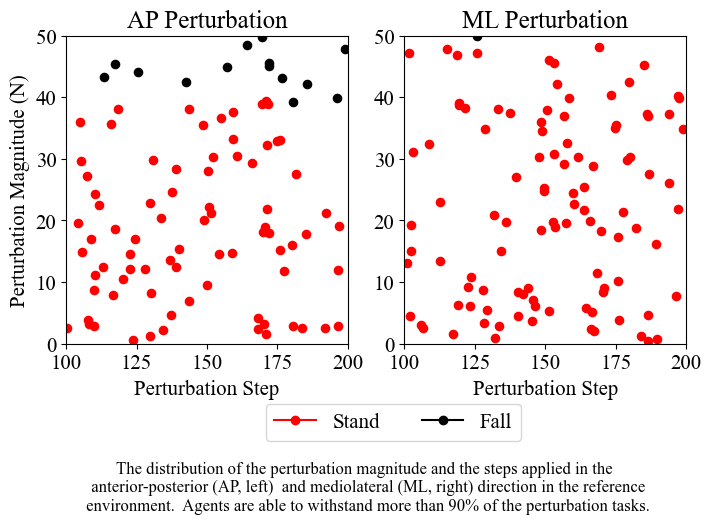

In [3]:
##plot 1, perturbation AP-ML plot
plt.rcParams.update({
    "font.family": "Times New Roman",  # specify font family here
    "font.size":15}) 

plt. figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for item in AP_pert_1:
    bos_final = item['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(item['bodyInfo']['com'][0])
    if within:
        color = 'red'
    else:

        color = 'black'
    plt.scatter(item['modelInfo']['perturbationTime']*100, item['modelInfo']['perturbationMagnitude'], s =35,
                color = color)

plt.xlabel('Perturbation Step')
plt.title('AP Perturbation')
plt.ylabel('Perturbation Magnitude (N)')
plt.xlim([100, 200])
plt.ylim([0, 50])

plt.subplot(1, 2, 2)
for item in ML_pert_1:
    bos_final = item['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(item['bodyInfo']['com'][0])
    if within:
        color = 'red'
    else:
        color = 'black'
    plt.scatter(x = item['modelInfo']['perturbationTime']*100, y = item['modelInfo']['perturbationMagnitude'], s = 35,color=color) 

plt.title('ML Perturbation')
plt.xlim([100, 200])
plt.ylim([0, 50])
plt.xlabel('Perturbation Step')
#plt.ylabel('Perturbation Magnitude (N)')

legend_elements = [Line2D([0], [0], marker='o', color='r', label='Stand',
                          markerfacecolor='r', markersize=6),
                   Line2D([0], [0], marker='o', color='black', label='Fall',
                          markerfacecolor='black', markersize=6)
                   ]

plt.legend(handles=legend_elements, bbox_to_anchor=(0.45, -0.35), loc="lower right", ncol = 2)
txt="The distribution of the perturbation magnitude and the steps applied in the \n  anterior-posterior (AP, left)  and mediolateral (ML, right) direction in the reference \n environment.  Agents are able to withstand more than 90% of the perturbation tasks."
plt.figtext(0.5, -0.3, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.close()

#### Part 4.1.2 Trajectory of COM of reference subject

C:\Users\chery\AppData\Local\Temp\ipykernel_20828\2016710748.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=bins)


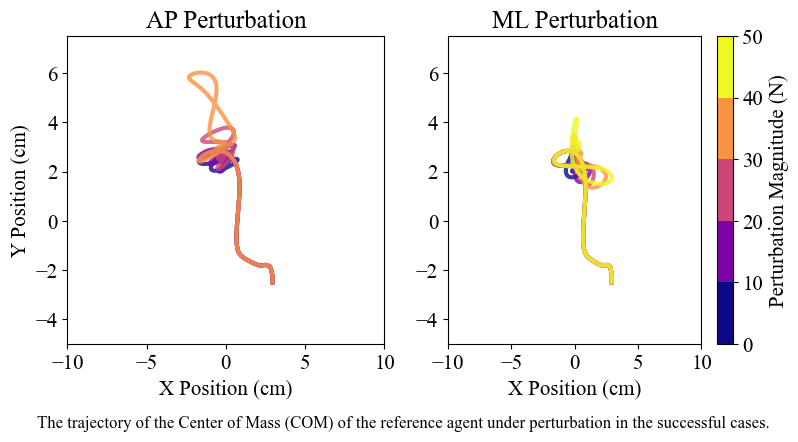

In [4]:
#plot the com variation
plt. figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
bins = [0, 10, 20, 30, 40, 50]

# Get the 'YlGn' colormap
colormap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bins, colormap.N)


for i in range(len(pert_AP)):
    mean_pert = []
    pertAP_1_com, pertAP_2_com, pertAP_3_com, pertAP_4_com, pertAP_5_com = [], [], [], [], []
    pertAP_com = [pertAP_1_com, pertAP_2_com, pertAP_3_com, pertAP_4_com, pertAP_5_com]
    for j in pert_AP[i]:
        mean_pert.append(j["modelInfo"]["perturbationMagnitude"])
        pertAP_com[i].append(j["bodyInfo"]["com"])
    if not pertAP_com[i]:
        continue

    plt.plot((np.mean(pertAP_com[i], axis = 0)[:,0] + 0.03)*100, (np.mean(pertAP_com[i], axis = 0)[:,1]-0.07)*100, c=colormap(norm(np.mean(mean_pert))), alpha = 0.8, linewidth = 3)#, cmap=cmap, norm=norm)

plt.xlabel('X Position (cm)')
plt.title('AP Perturbation')
plt.ylabel('Y Position (cm)')
plt.ylim([-5, 7.5])
plt.xlim([-10, 10])

plt.subplot(1, 2, 2)
for i in range(len(pert_ML)):
    mean_pert = []
    pertML_1_com, pertML_2_com, pertML_3_com, pertML_4_com, pertML_5_com = [], [], [], [], []
    pertML_com = [pertML_1_com, pertML_2_com, pertML_3_com, pertML_4_com, pertML_5_com]
    for j in pert_ML[i]:
        mean_pert.append(j["modelInfo"]["perturbationMagnitude"])
        pertML_com[i].append(j["bodyInfo"]["com"])
    if not pertML_com[i]:
        continue

    plt.plot((np.mean(pertML_com[i], axis = 0)[:,0]+ 0.03)*100, (np.mean(pertML_com[i], axis = 0)[:,1] - 0.07)*100, c=colormap(norm(np.mean(mean_pert))), alpha = 0.8, linewidth = 3)

plt.xlabel('X Position (cm)')
plt.title('ML Perturbation')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=bins)
cbar.set_label('Perturbation Magnitude (N)')

plt.ylim([-5, 7.5])
plt.xlim([-10, 10])
txt="The trajectory of the Center of Mass (COM) of the reference agent under perturbation in the successful cases. "
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.close()

#### Part 4.1.3 Distribution of the joint angle and torque in reference subject

In [5]:
#acquiring the joints information
ankle_angle_l, ankle_angle_r, hip_adduction_l, hip_adduction_r, hip_rotation_l, hip_rotation_r = [], [], [], [], [], []
hip_flexion_l, hip_flexion_r, knee_angle_l,  knee_angle_r, mtp_angle_l, mtp_angle_r, subtalar_angle_l, subtalar_angle_r = [], [], [], [], [], [], [], []

joint_name_qpos = [ankle_angle_l, ankle_angle_r, hip_adduction_l, hip_adduction_r, hip_rotation_l, 
                    hip_rotation_r, knee_angle_l,  knee_angle_r, mtp_angle_l, mtp_angle_r, hip_flexion_l, hip_flexion_r, subtalar_angle_l, subtalar_angle_r ]

ankle_angle_l_t, ankle_angle_r_t, hip_adduction_l_t, hip_adduction_r_t, hip_rotation_l_t = [], [], [], [], []
hip_rotation_r_t, knee_angle_l_t, knee_angle_r_t, mtp_angle_l_t, mtp_angle_r_t =[], [], [], [], []
hip_flexion_l_t, hip_flexion_r_t, subtalar_angle_l_t, subtalar_angle_r_t = [], [], [], []

joint_name_torque = [ankle_angle_l_t, ankle_angle_r_t, hip_adduction_l_t, hip_adduction_r_t, hip_rotation_l_t, 
                     hip_rotation_r_t, knee_angle_l_t, knee_angle_r_t, mtp_angle_l_t, mtp_angle_r_t, hip_flexion_l_t, 
                     hip_flexion_r_t, subtalar_angle_l_t, subtalar_angle_r_t]


joint_names_l = ['ankle_angle_l', 'hip_adduction_l', 'hip_rotation_l', 'knee_angle_l', 'mtp_angle_l',  'hip_flexion_l', 'subtalar_angle_l']
title = ['Ankle', 'Hip Adduction', 'Hip Rotation', 'Knee Angle', 'MTP Angle', 'Hip Flexion', 'Subtalar Angle']
joint_names_r = ['ankle_angle_r', 'hip_adduction_r','hip_rotation_r', 'knee_angle_r','mtp_angle_r','hip_flexion_r',  'subtalar_angle_r' ]

Here, we plot the joint angle and torque changes over 1000 steps, averaged over
AP and ML direction perturbation

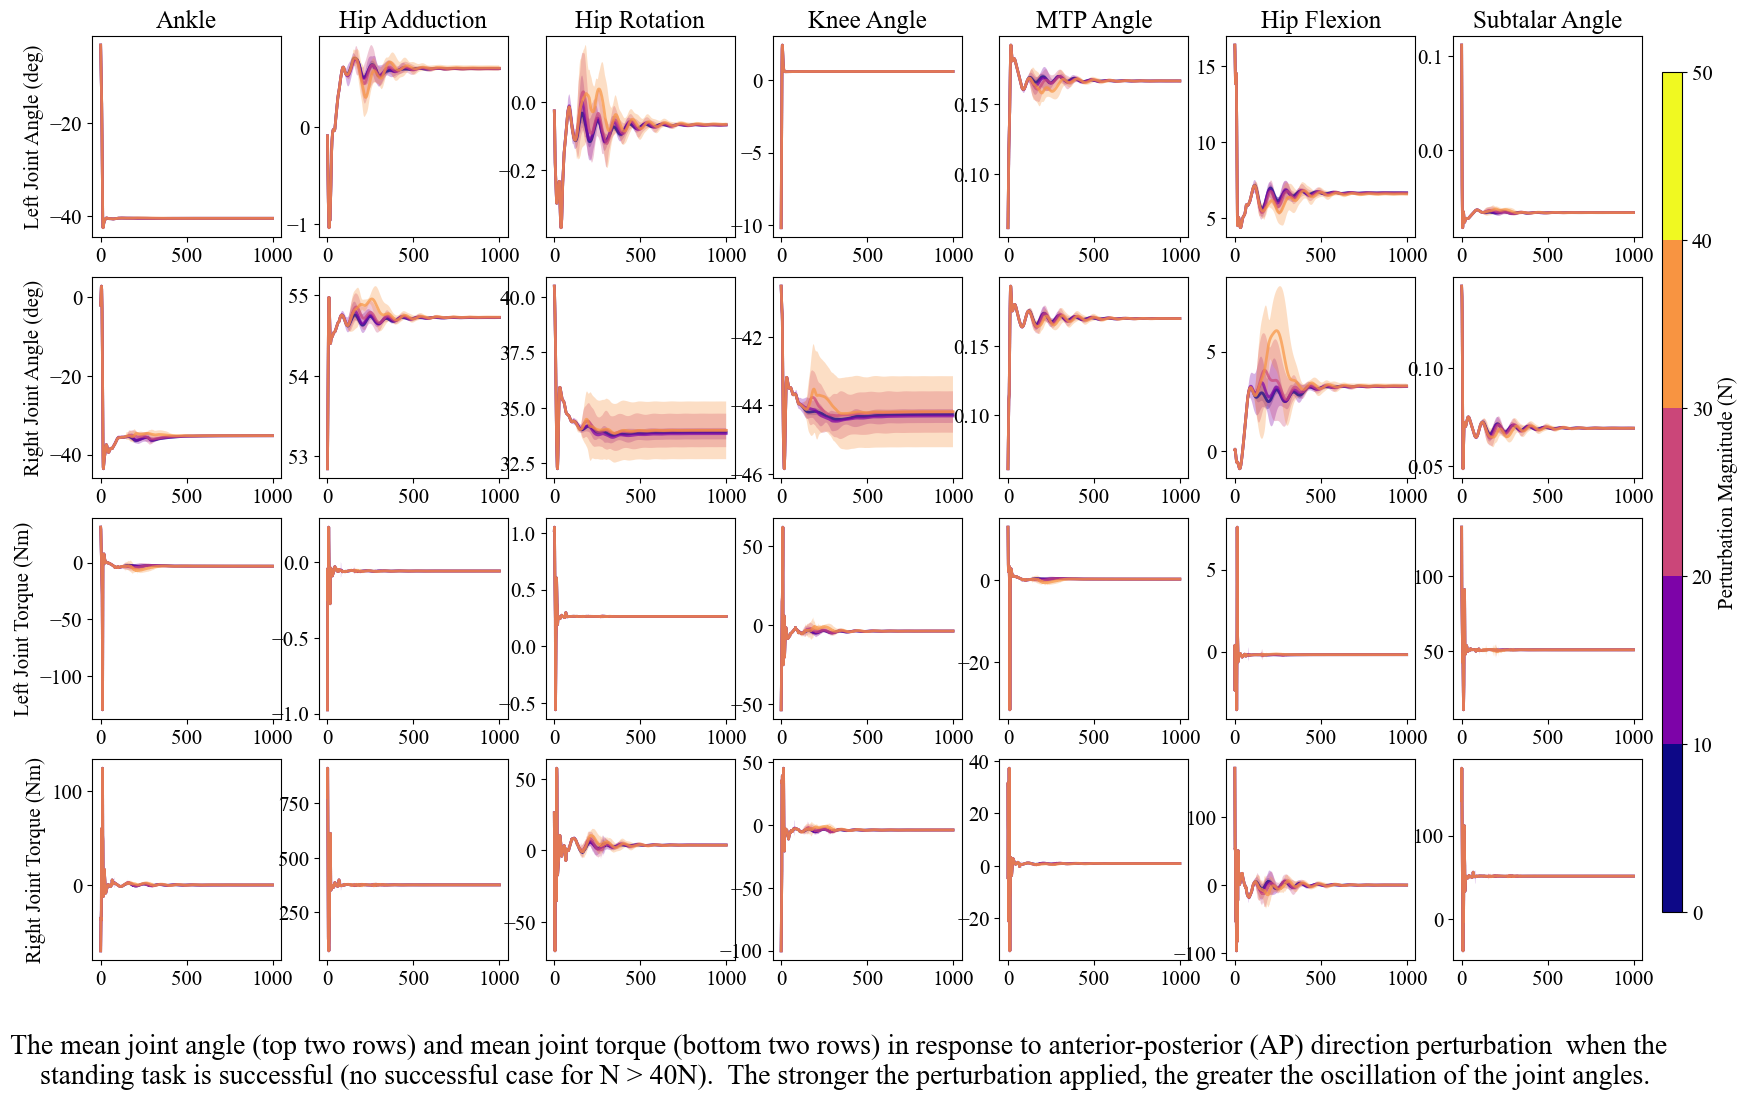

In [34]:
#####plotting the joint angle over time for standing up case
y_range_joint = [-50, 50]

colormap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bins, colormap.N)
fig = plt.figure(figsize=(20, 12))
for i in range(0, 7):
    plt.subplot(4, 7, i+1)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)*180/np.pi
            std = np.std(l[j], axis = 0)*180/np.pi
            plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(title[i])
    if i == 0:
        plt.ylabel('Left Joint Angle (deg)')
######

for i in range(0, 7):
    plt.subplot(4, 7, i+8)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)*180/np.pi
            std = np.std(l[j], axis = 0)*180/np.pi
            plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Angle (deg)')

for i in range(0, 7):
    plt.subplot(4, 7, i+15)
    for j in range(len(pert_AP)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Left Joint Torque (Nm)')


for i in range(0, 7):
    plt.subplot(4, 7, i+22)
    for j in range(len(pert_AP)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Torque (Nm)')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm) 
sm.set_array([]) 

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('Perturbation Magnitude (N)')

txt="The mean joint angle (top two rows) and mean joint torque (bottom two rows) with 2SD in response to anterior-posterior (AP) direction perturbation  when the \n standing task is successful (no successful case for N > 40N).  The stronger the perturbation applied, the greater the oscillation of the joint angles."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()
plt.close()


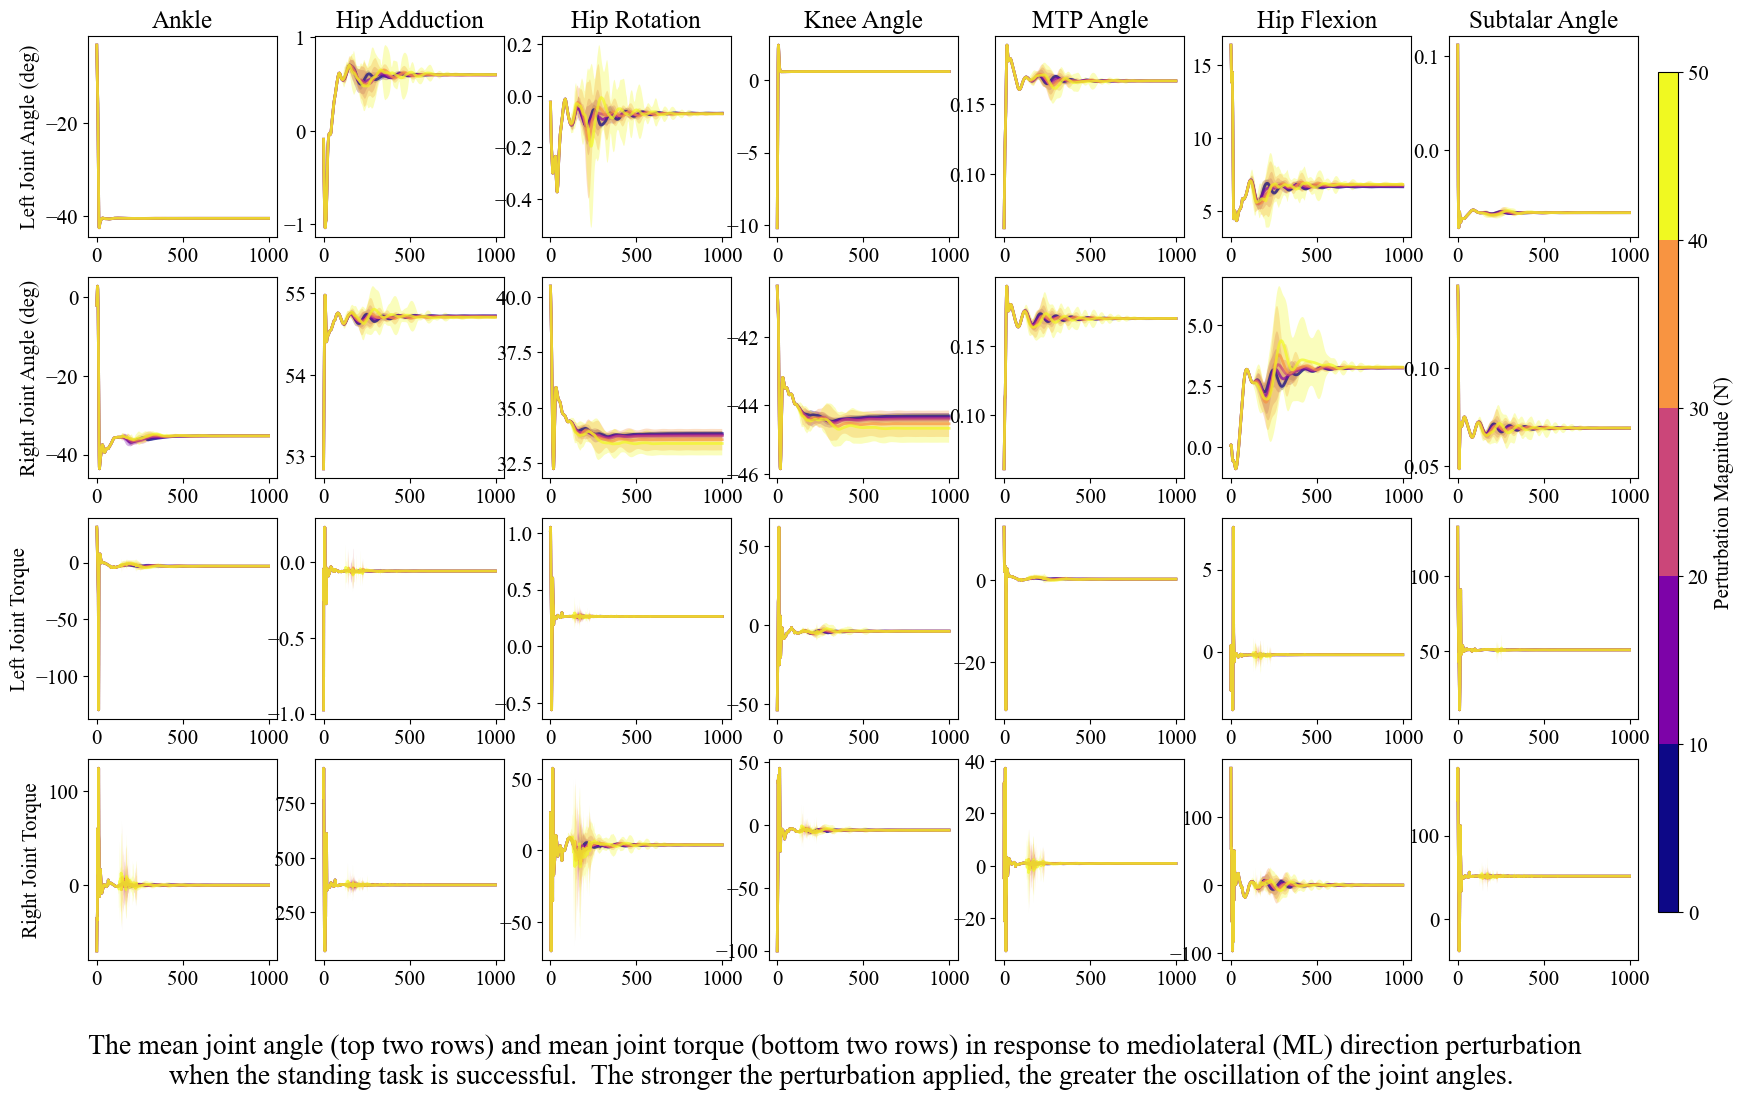

In [29]:
###ML direction
norm = mcolors.BoundaryNorm(bins, colormap.N)
fig = plt.figure(figsize=(20, 12))
for i in range(0, 7):
    plt.subplot(4, 7, i+1)
    for j in range(len(pert_ML)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)*180/np.pi
        std = np.std(l[j], axis = 0)*180/np.pi
        plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(title[i])
    if i == 0:
        plt.ylabel('Left Joint Angle (deg)')
######

for i in range(0, 7):
    plt.subplot(4, 7, i+8)
    for j in range(len(pert_ML)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)*180/np.pi
        std = np.std(l[j], axis = 0)*180/np.pi
        plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Angle (deg)')

for i in range(0, 7):
    plt.subplot(4, 7, i+15)
    for j in range(len(pert_ML)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        std = np.std(l[j], axis = 0)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Left Joint Torque')


for i in range(0, 7):
    plt.subplot(4, 7, i+22)
    for j in range(len(pert_ML)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_r[i]])
            #print(k['jointInfo']['qtau']['subtalar_angle_r'])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        #print(mean)
        std = np.std(l[j], axis = 0)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Torque')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm) 
sm.set_array([]) 

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('Perturbation Magnitude (N)')
txt="The mean joint angle (top two rows) and mean joint torque (bottom two rows) with 2SD in response to mediolateral (ML) direction perturbation \n when the standing task is successful.  The stronger the perturbation applied, the greater the oscillation of the joint angles."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()
plt.close()

#### Part 4.1.4 Muscle activation in reference subject
There are 80 actuators that we can control. Here we ignore cases when muscle activation is too low and plot the rest.

In [49]:
######draw muscle activation diagram
actuator_names =  ['addbrev_l', 'addbrev_r', 'addlong_l', 'addlong_r', 'addmagDist_l', 'addmagDist_r', 'addmagIsch_l', 
                       'addmagIsch_r', 'addmagMid_l', 'addmagMid_r', 'addmagProx_l', 'addmagProx_r', 'bflh_l', 'bflh_r', 'bfsh_l', 
                       'bfsh_r', 'edl_l', 'edl_r', 'ehl_l', 'ehl_r', 'fdl_l', 'fdl_r', 'fhl_l', 'fhl_r', 'gaslat_l', 'gaslat_r', 
                       'gasmed_l', 'gasmed_r', 'glmax1_l', 'glmax1_r', 'glmax2_l', 'glmax2_r', 'glmax3_l', 'glmax3_r', 'glmed1_l', 
                       'glmed1_r', 'glmed2_l', 'glmed2_r', 'glmed3_l', 'glmed3_r', 'glmin1_l', 'glmin1_r', 'glmin2_l', 'glmin2_r', 
                       'glmin3_l', 'glmin3_r', 'grac_l', 'grac_r', 'iliacus_l', 'iliacus_r', 'perbrev_l', 'perbrev_r', 'perlong_l', 
                       'perlong_r', 'piri_l', 'piri_r', 'psoas_l', 'psoas_r', 'recfem_l', 'recfem_r', 'sart_l', 'sart_r', 'semimem_l', 
                       'semimem_r', 'semiten_l', 'semiten_r', 'soleus_l', 'soleus_r', 'tfl_l', 'tfl_r', 'tibant_l', 'tibant_r', 'tibpost_l', 
                       'tibpost_r', 'vasint_l', 'vasint_r', 'vaslat_l', 'vaslat_r', 'vasmed_l', 'vasmed_r']



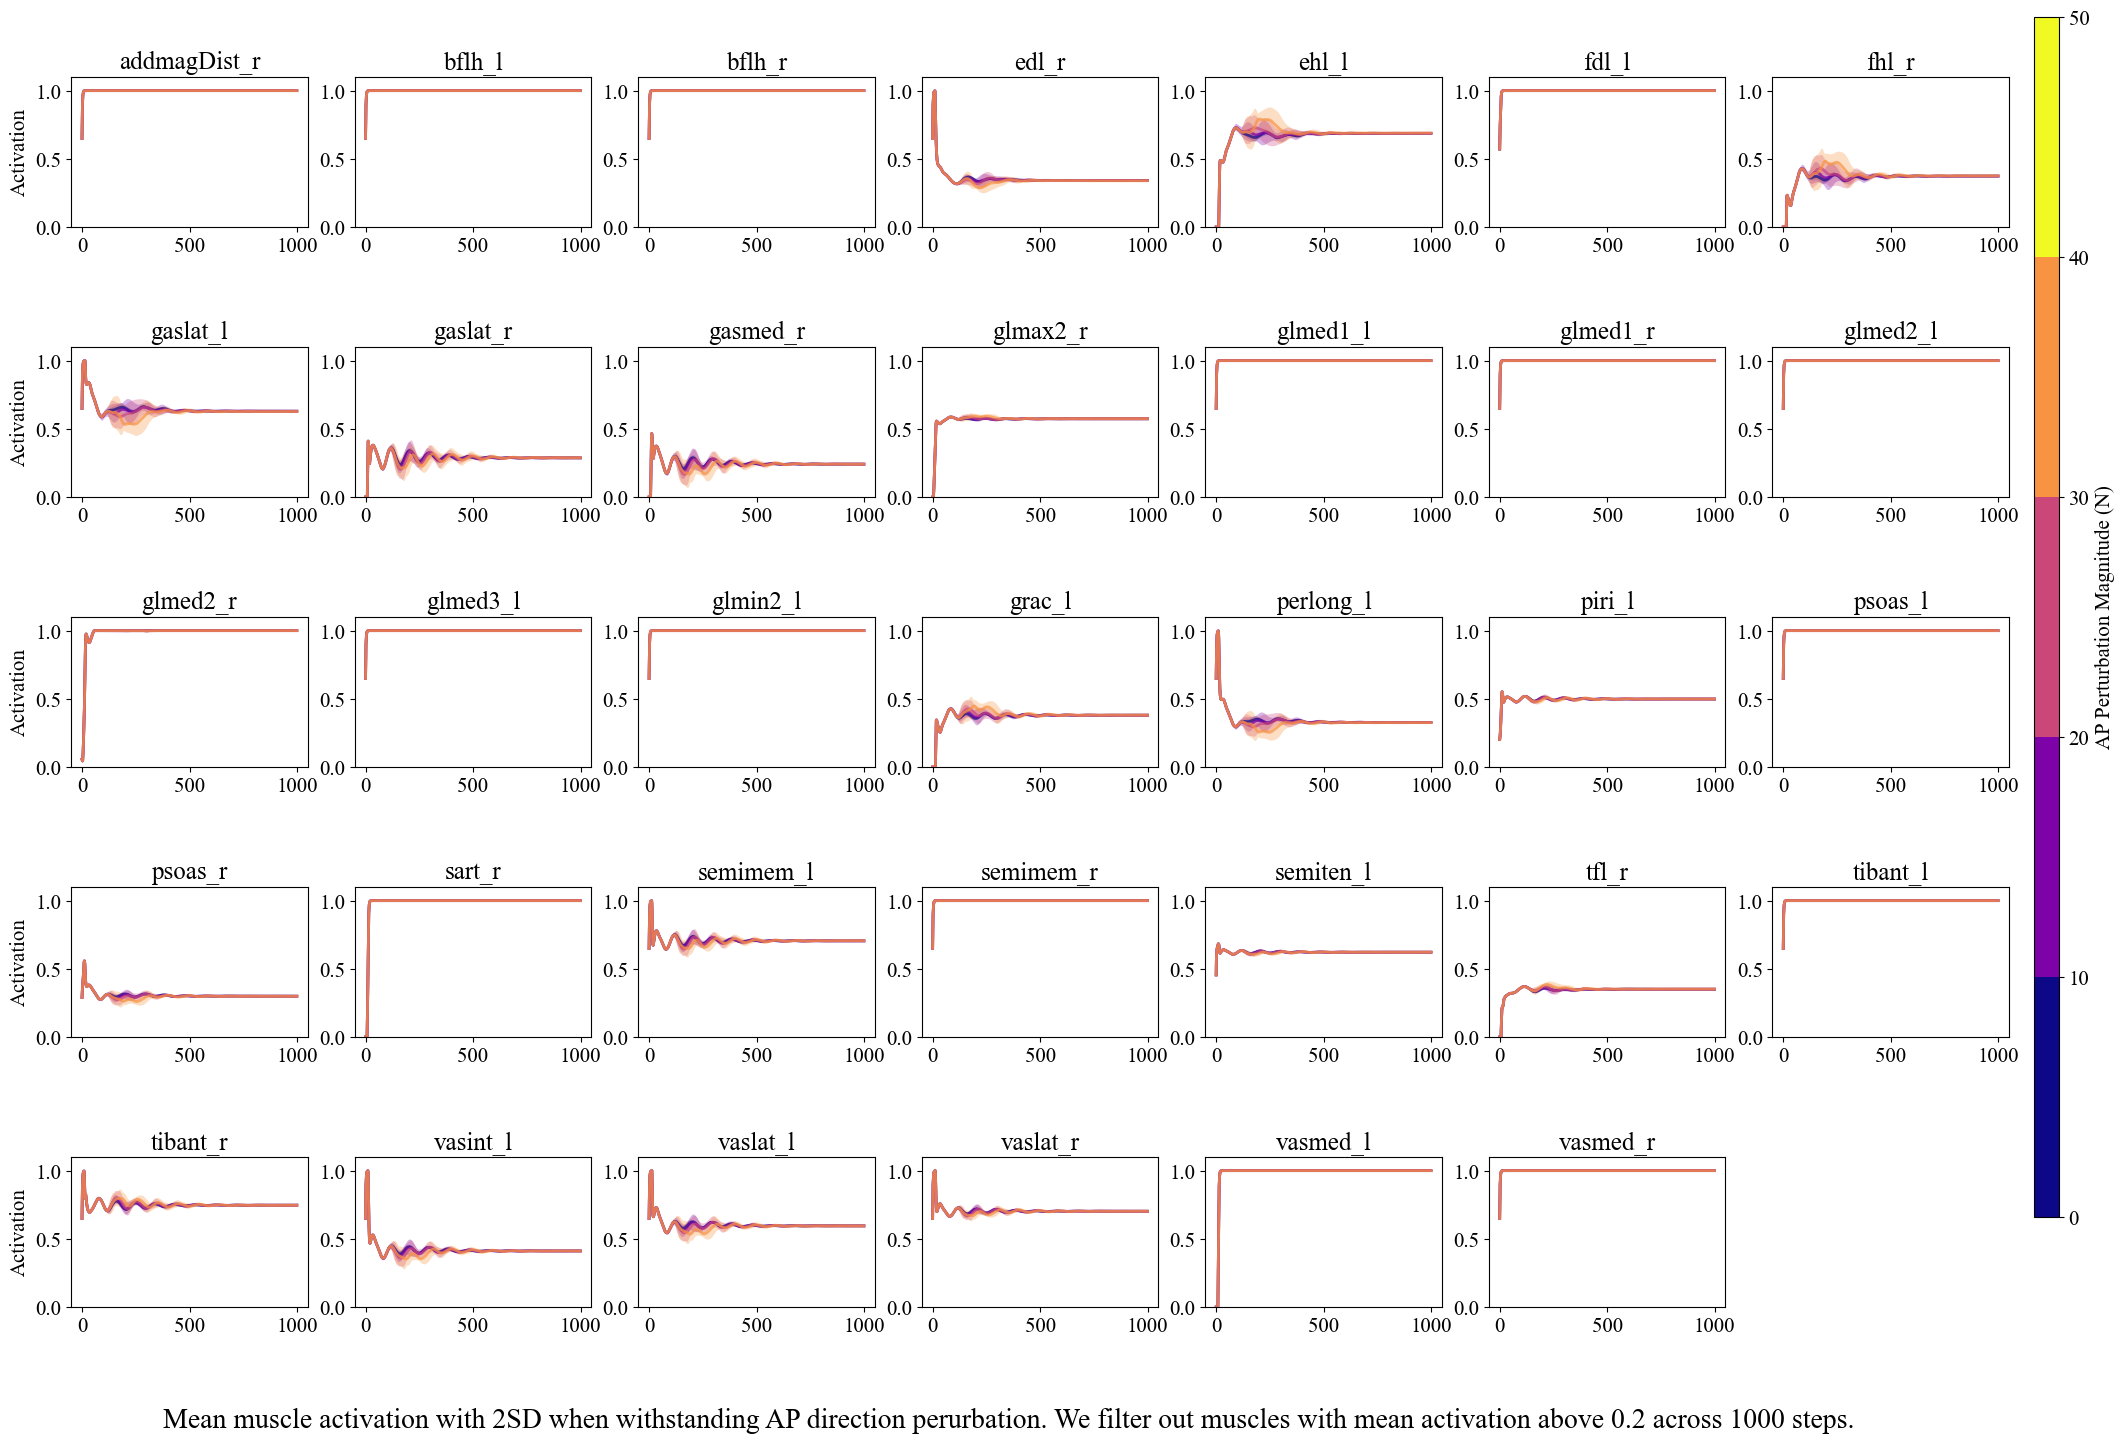

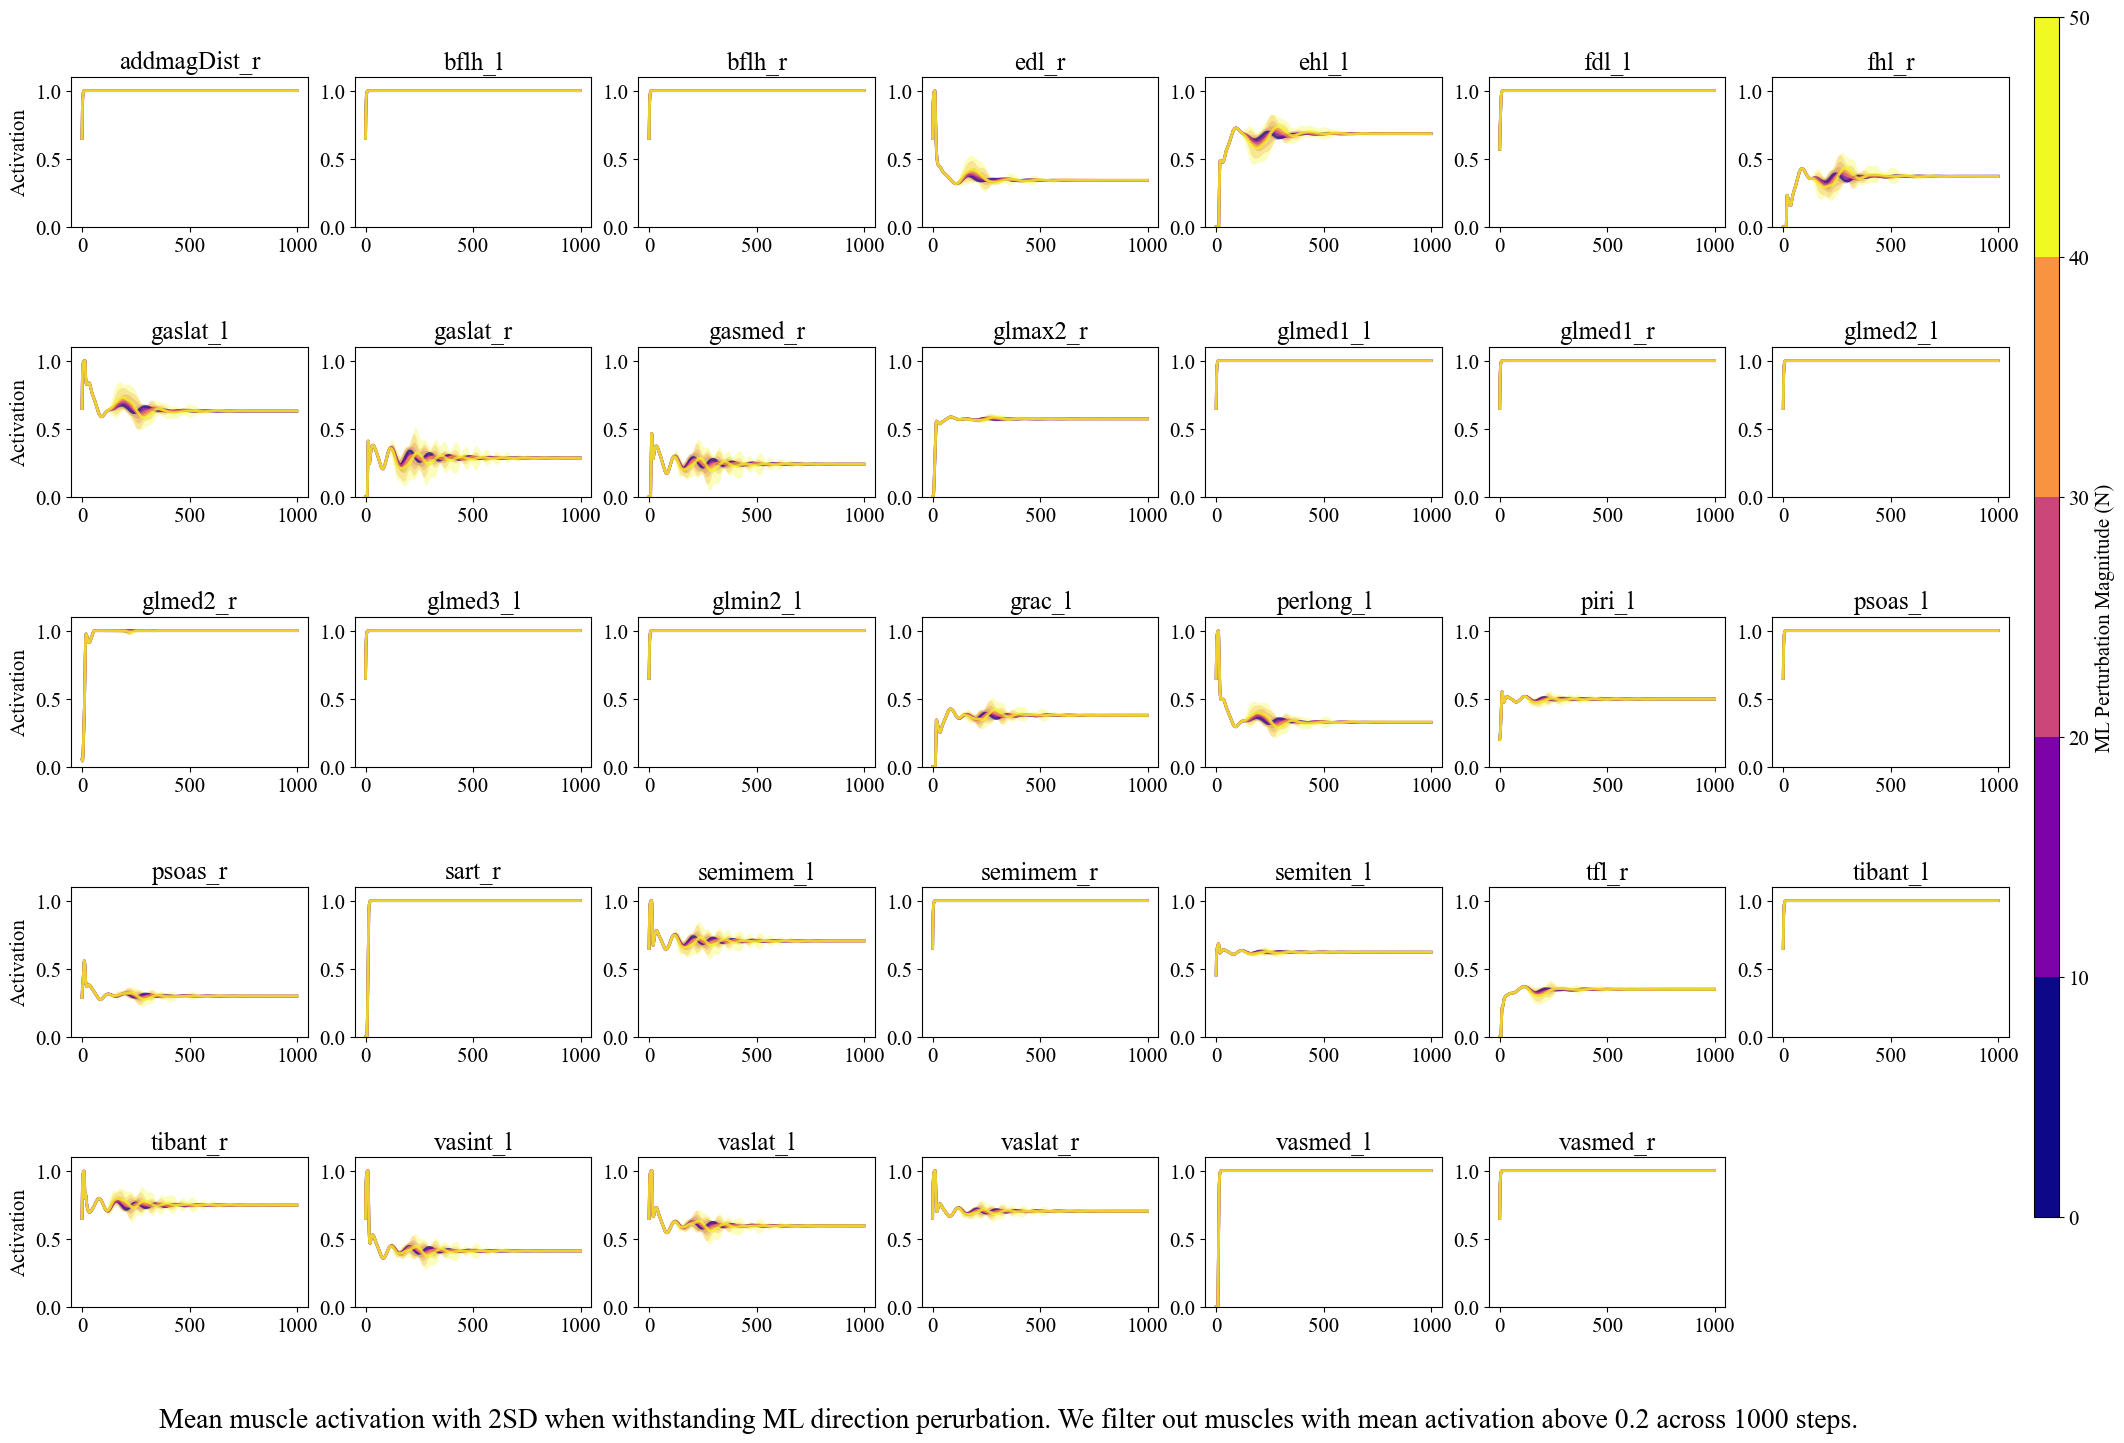

In [70]:
## filter out muscles with very little activations
active_actuator = []
for names in actuator_names:
    act_all = []
    for k in AP_pert:
        act = k['muscleInfo']['muscleActivation'][names]
        #print(len(act))
        act_all.append(act)
        #print(np.mean(act_all, axis=0))
    if np.mean(np.mean(act_all, axis = 0)) > 0.2:
        active_actuator.append(names)

n1 = len(active_actuator)//4 + 1

fig = plt.figure(figsize=(25, 30))#, constrained_layout = True)
plt.subplots_adjust(hspace=0.8)
for i in range(0, len(active_actuator)):
    plt.subplot(n1, 7, i+1)
    l1, l2, l3, l4, l5 = [], [], [], [], []
    l = [l1, l2, l3, l4, l5]
    for j in range(len(pert_AP)):
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['muscleInfo']['muscleActivation'][active_actuator[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else: 
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.title(active_actuator[i], usetex =False)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if (i)%7 == 0 :
        plt.ylabel('Activation')
    plt.ylim([0, 1.1])

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.5, 0.01, 0.4])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('AP Perturbation Magnitude (N)')
txt="Mean muscle activation with 2SD when withstanding AP direction perurbation. We filter out muscles with mean activation above 0.2 across 1000 steps."
plt.figtext(0.5, 0.43, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.show()
plt.close()


## muscle activation in ML perturbation situation
active_actuator = []
for names in actuator_names:
    act_all = []
    for k in ML_pert:
        act = k['muscleInfo']['muscleActivation'][names]
        #print(len(act))
        act_all.append(act)
        #print(np.mean(act_all, axis=0))
    if np.mean(np.mean(act_all, axis = 0)) > 0.2:
        active_actuator.append(names)



fig = plt.figure(figsize=(25, 30))
plt.subplots_adjust(hspace=0.8)
for i in range(0, len(active_actuator)):
    plt.subplot(n1, 7, i+1)
    l1, l2, l3, l4, l5 = [], [], [], [], []
    l = [l1, l2, l3, l4, l5]
    for j in range(len(pert_ML)):
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['muscleInfo']['muscleActivation'][active_actuator[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        std = np.std(l[j], axis = 0)
        plt.title(active_actuator[i], usetex =False)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if (i)%7 == 0 :
        plt.ylabel('Activation')
    plt.ylim([0, 1.1])

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.5, 0.01, 0.4])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('ML Perturbation Magnitude (N)')
txt="Mean muscle activation with 2SD when withstanding ML direction perurbation. We filter out muscles with mean activation above 0.2 across 1000 steps."
plt.figtext(0.5, 0.43, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.show()
plt.close()

### 4.2 Results for sarcopenia subjects

For simplicity, we combine all the plot codes together.

In [3]:
sarco =  True

if sarco:
    name = '2023_12_04_18_29_11'
    env_name = 'myoSarcLegReachFixed-v3'
else:
    name = '2023_11_22_17_43_32'
    env_name = 'myoLegReachFixed-v2'
steps = 1000
pkl_path = './output/PKL/' + env_name + '/'
ep = 200


def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

image_path = './image/' + env_name + '/' + name
os.makedirs(image_path, exist_ok=True)

In [4]:
AP_pert = []
AP_pert_1, ML_pert_1= [], []#this is only used for the scatter stand/fall plot
ML_pert = []
stand = []
fall = []
pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP = [], [], [], [], []
pert_1_ML, pert_2_ML, pert_3_ML, pert_4_ML, pert_5_ML = [], [], [], [], []
for i in range(ep):
    file_path = pkl_path + name+f'_{i}.pkl'  # Replace with actual file paths
    data = load_pickle(file_path)
    bos_final = data['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(data['bodyInfo']['com'][0])
    if within:
        stand.append(data.copy())
    else:
        fall.append(data.copy())
    
    if data['modelInfo']['perturbationDirection'] == 1:
        AP_pert_1.append(data)
    else:
        ML_pert_1.append(data)

for data in stand:
    if data['modelInfo']['perturbationDirection'] == 1:
        AP_pert.append(data)
        if 0 <= data['modelInfo']['perturbationMagnitude'] <= 10:
            pert_1_AP.append(data)
        elif 10 <= data['modelInfo']['perturbationMagnitude'] <= 20:
            pert_2_AP.append(data)
        elif 20 <= data['modelInfo']['perturbationMagnitude'] <= 30:
            pert_3_AP.append(data)
        elif 30 <= data['modelInfo']['perturbationMagnitude'] <= 40:
            pert_4_AP.append(data)
        else:
            pert_5_AP.append(data)
    else:
        ML_pert.append(data)
        if 0 <= data['modelInfo']['perturbationMagnitude'] <= 10:
            pert_1_ML.append(data)
        elif 10 <= data['modelInfo']['perturbationMagnitude'] <= 20:
            pert_2_ML.append(data)
        elif 20 <= data['modelInfo']['perturbationMagnitude'] <= 30:
            pert_3_ML.append(data)
        elif 30 <= data['modelInfo']['perturbationMagnitude'] <= 40:
            pert_4_ML.append(data)
        else:
            pert_5_ML.append(data)

    
pert_AP = [pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP]
pert_ML = [pert_1_ML, pert_2_ML, pert_3_ML, pert_4_ML, pert_5_ML]

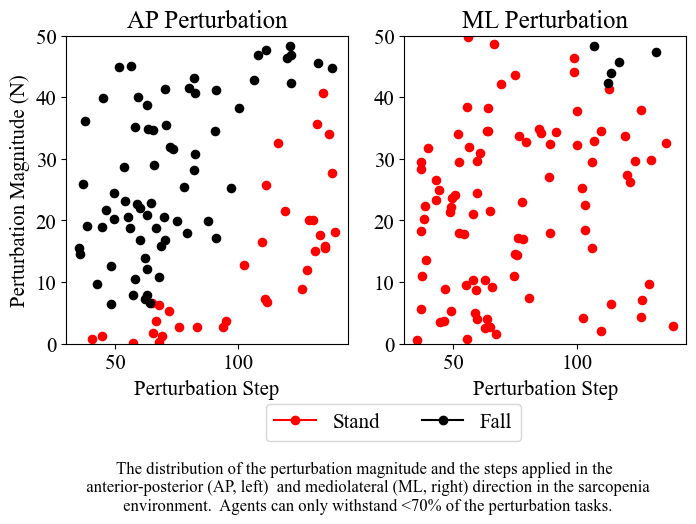

C:\Users\chery\AppData\Local\Temp\ipykernel_35352\3962651109.py:101: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=bins)


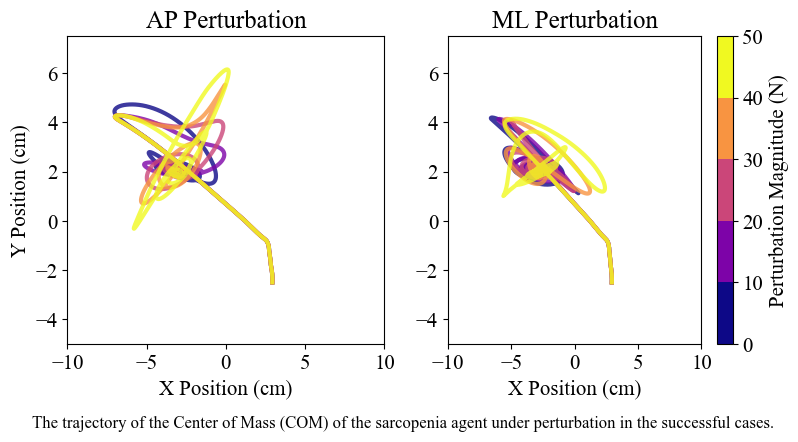

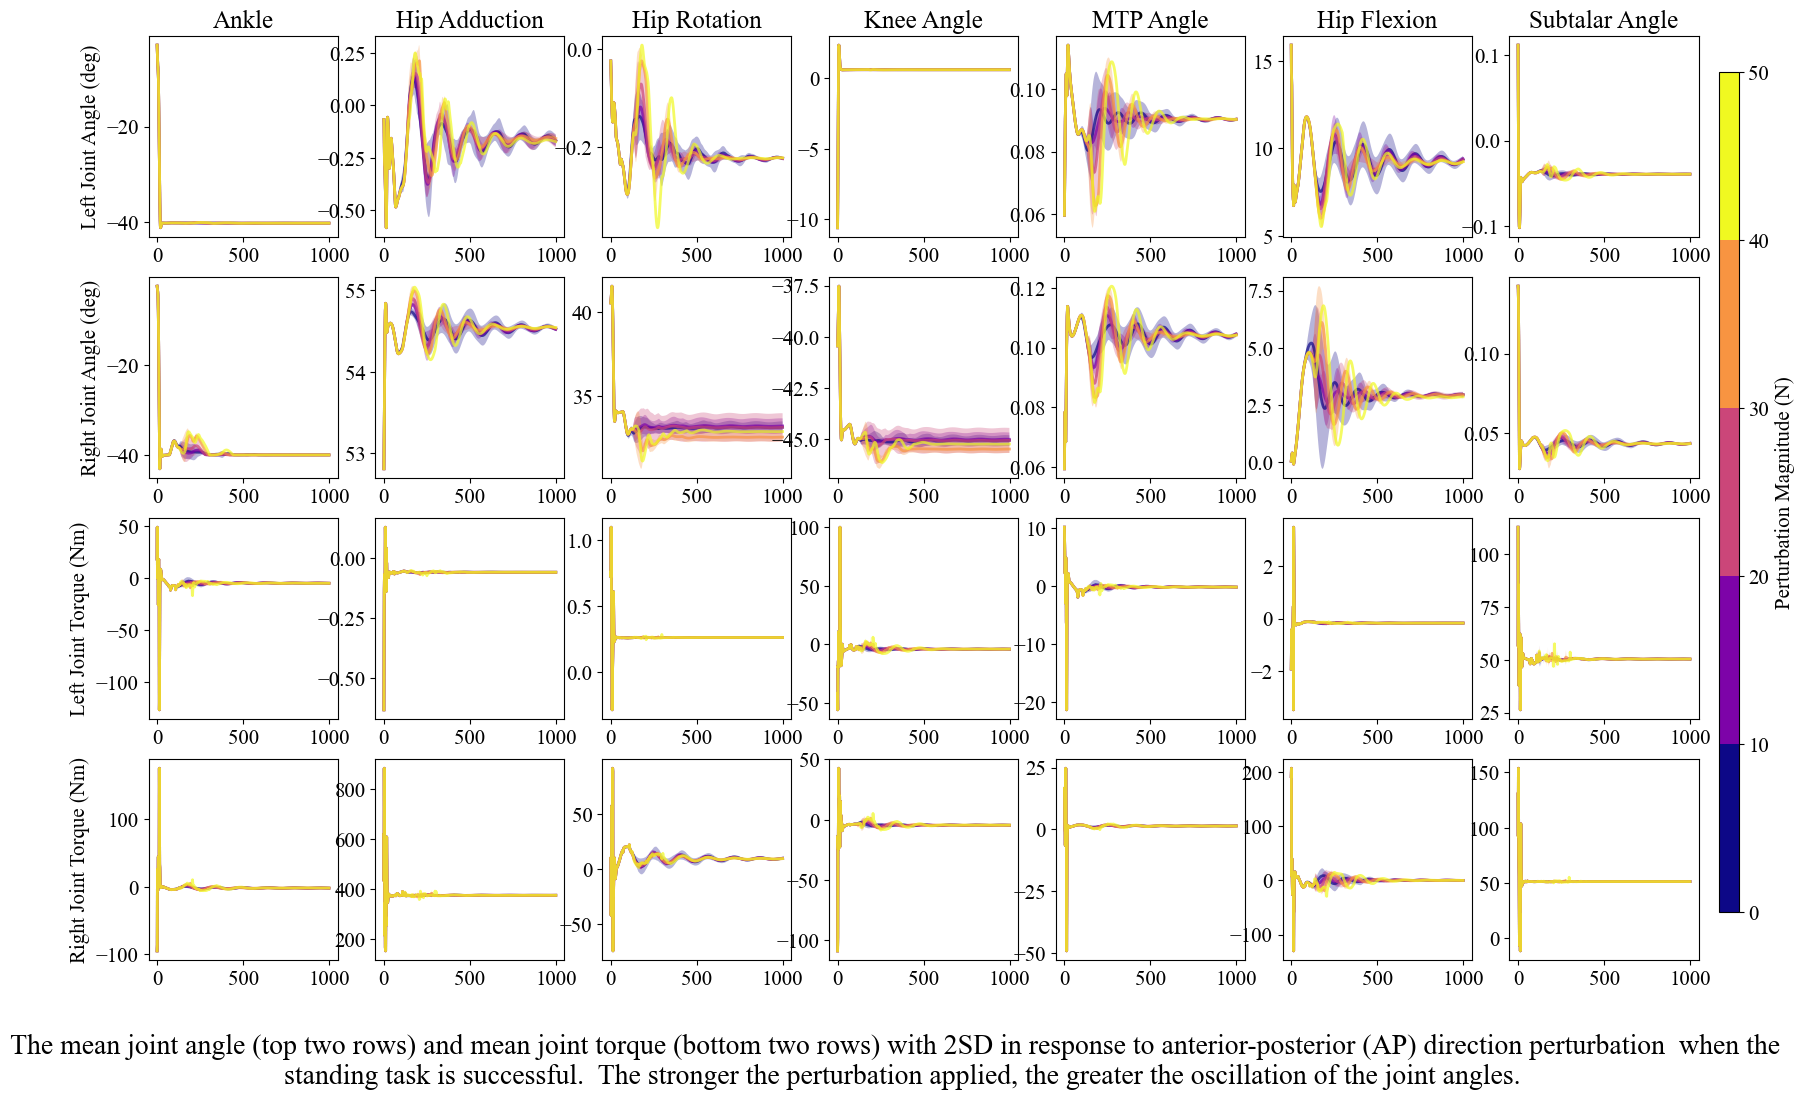

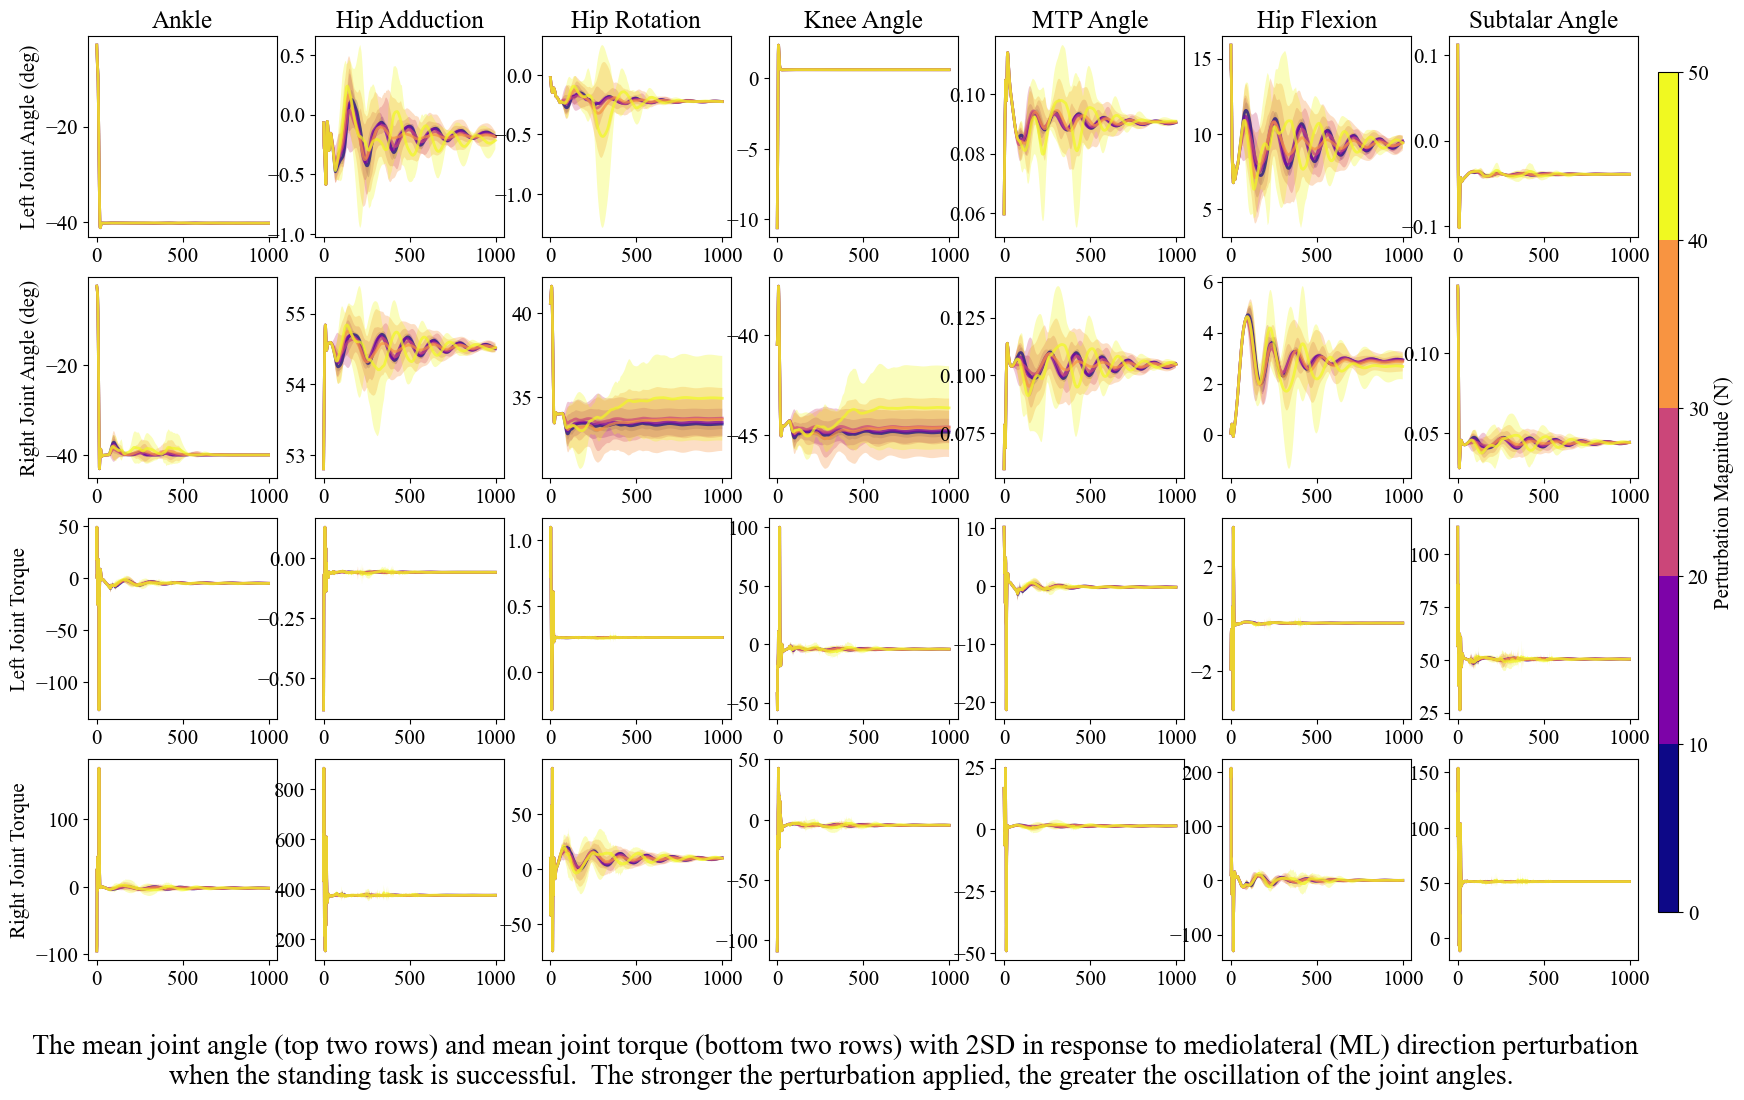

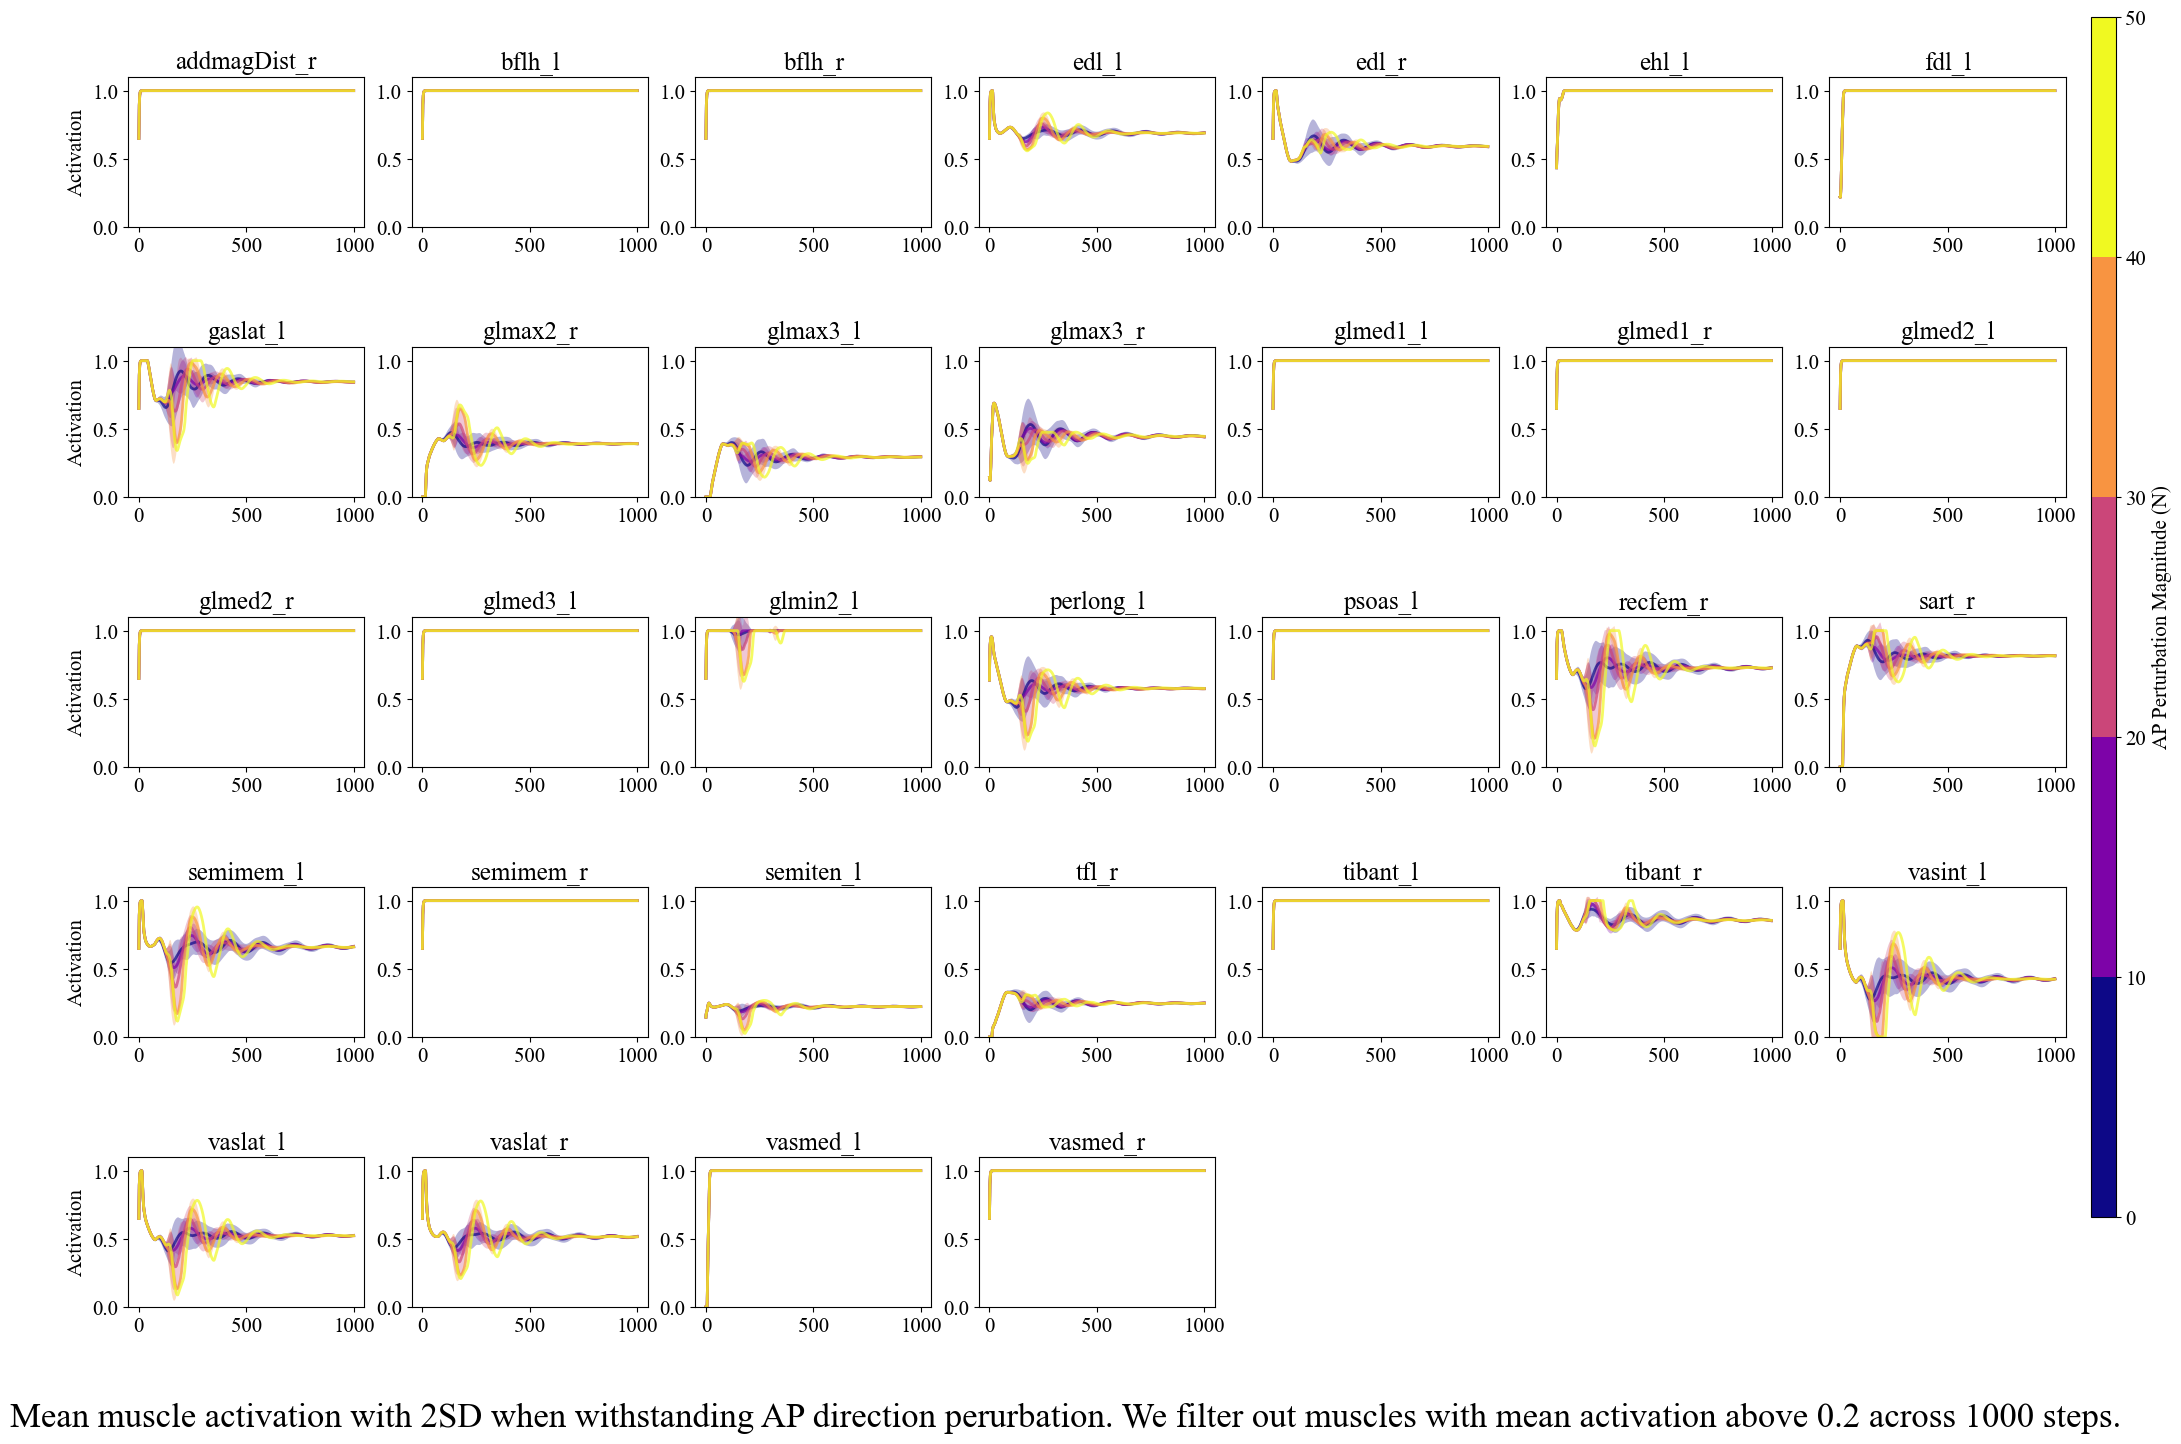

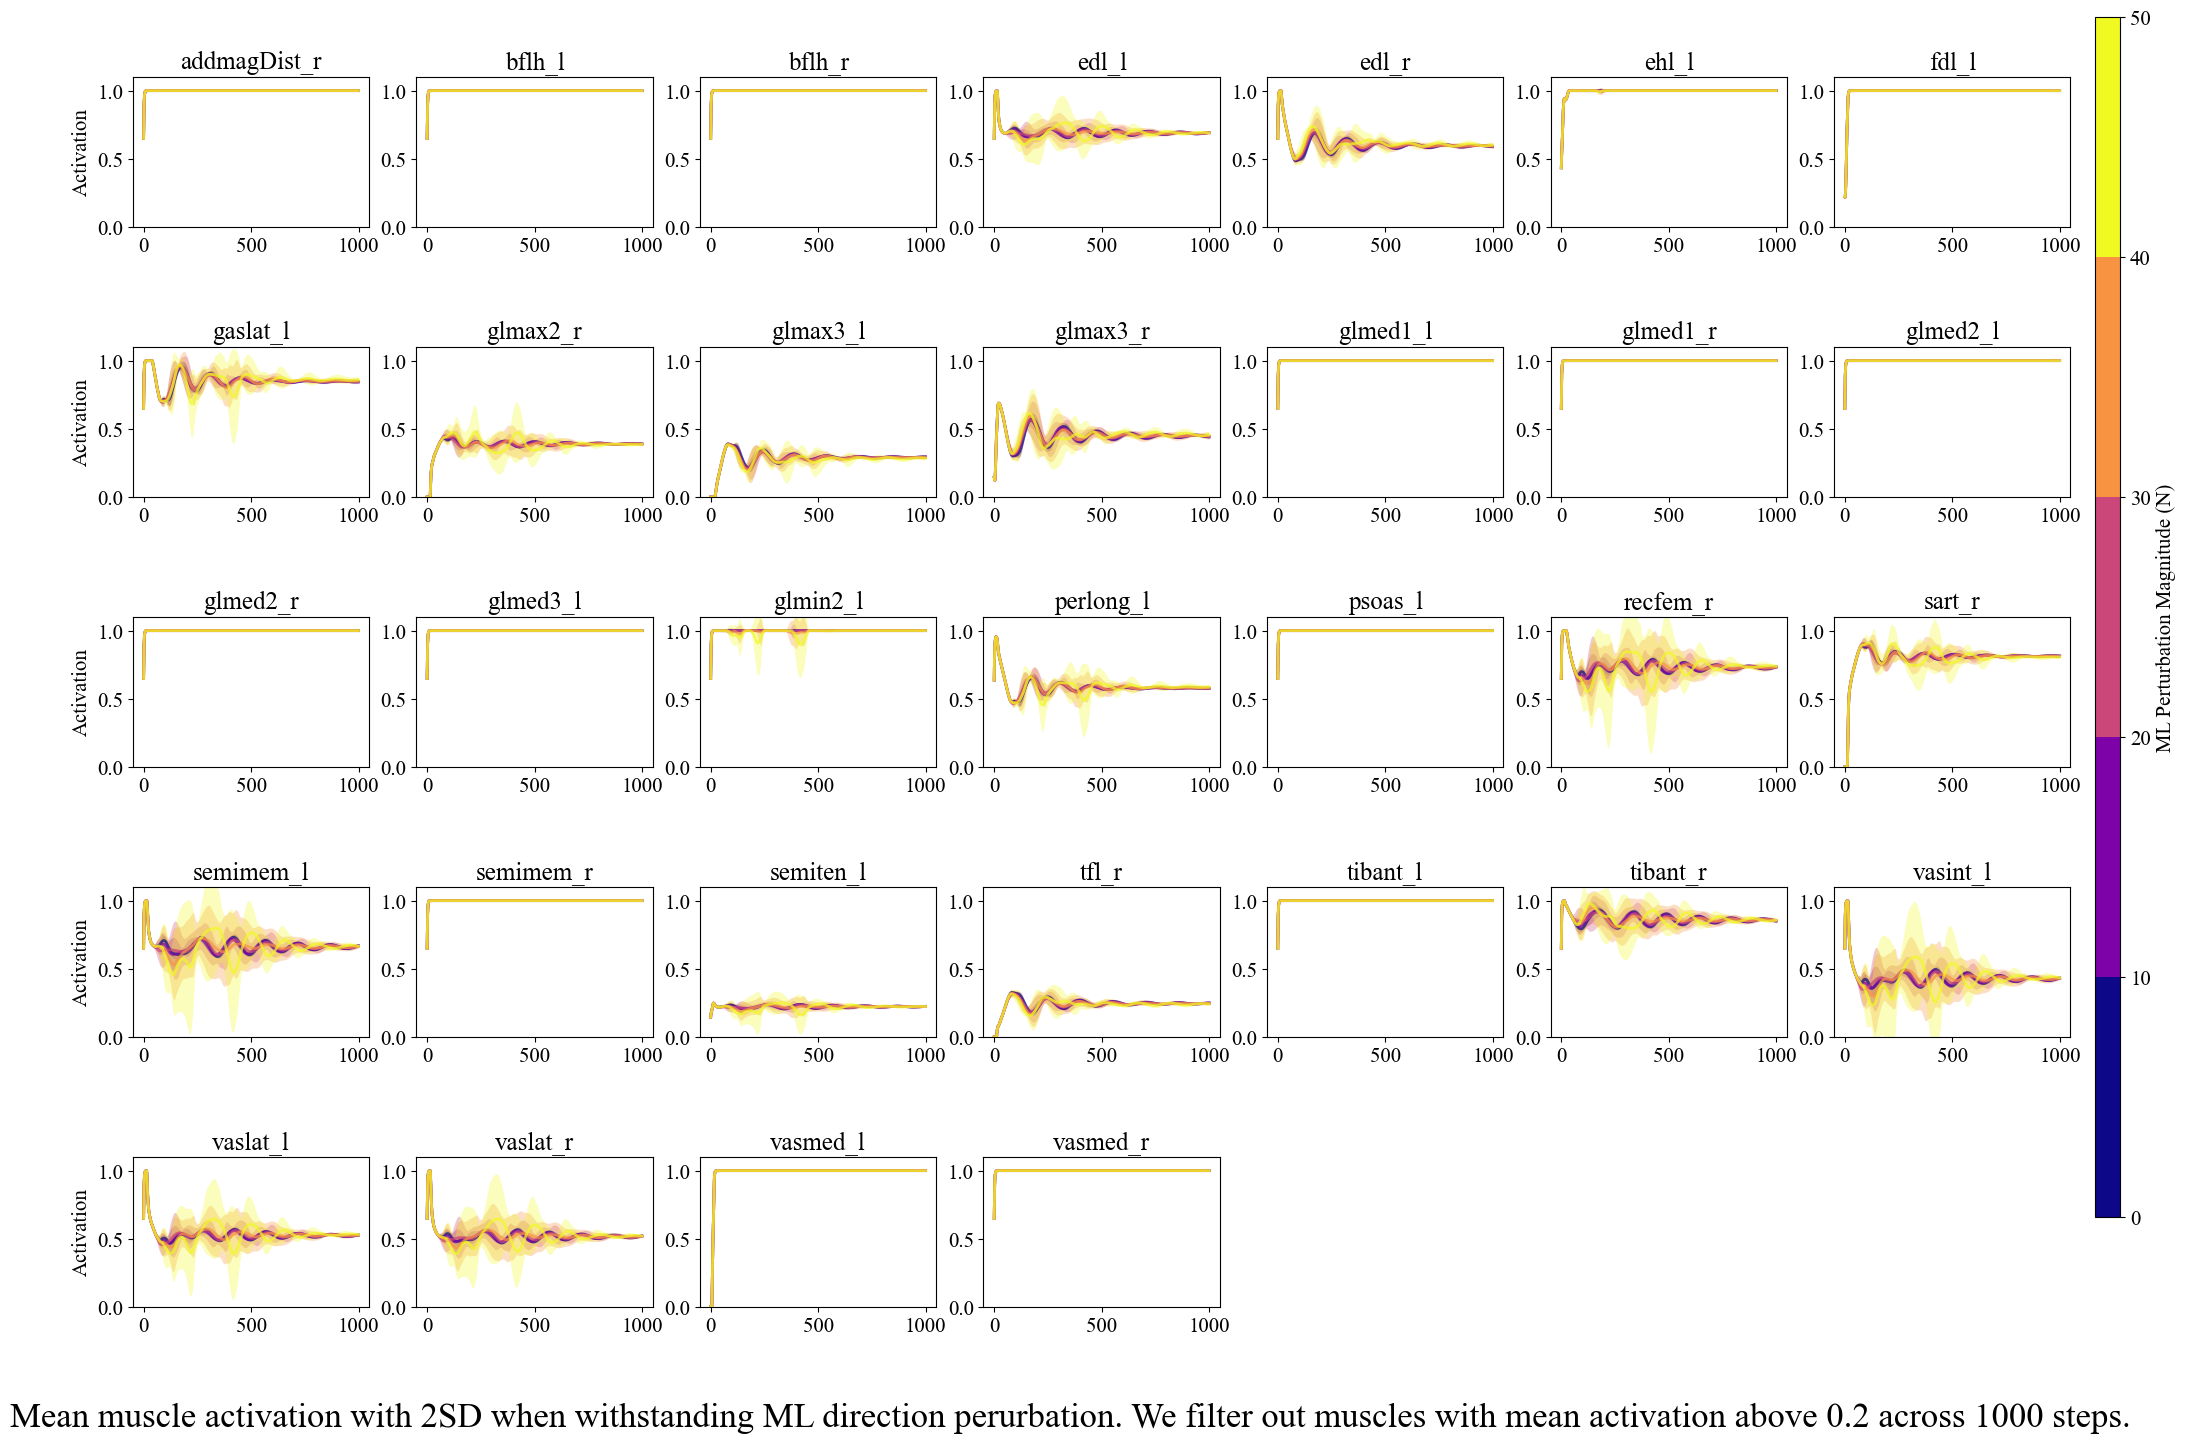

In [10]:
plt.rcParams.update({
    "font.family": "Times New Roman",  # specify font family here
    "font.size":15}) 

plt. figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for item in AP_pert_1:
    bos_final = item['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(item['bodyInfo']['com'][0])
    if within:
        color = 'red'
    else:

        color = 'black'
    plt.scatter(item['modelInfo']['perturbationTime']*100, item['modelInfo']['perturbationMagnitude'], s =35,
                color = color)

plt.xlabel('Perturbation Step')
plt.title('AP Perturbation')
plt.ylabel('Perturbation Magnitude (N)')
#plt.xlim([100, 200])
plt.ylim([0, 50])

plt.subplot(1, 2, 2)
for item in ML_pert_1:
    bos_final = item['bodyInfo']['bos'][-1].reshape(2, 4)
    bos_final = mplPath.Path(bos_final.T)
    within = bos_final.contains_point(item['bodyInfo']['com'][0])
    if within:
        color = 'red'
    else:
        color = 'black'
    plt.scatter(x = item['modelInfo']['perturbationTime']*100, y = item['modelInfo']['perturbationMagnitude'], s = 35,color=color) 

plt.title('ML Perturbation')
#plt.xlim([100, 200])
plt.ylim([0, 50])
plt.xlabel('Perturbation Step')
#plt.ylabel('Perturbation Magnitude (N)')

legend_elements = [Line2D([0], [0], marker='o', color='r', label='Stand',
                          markerfacecolor='r', markersize=6),
                   Line2D([0], [0], marker='o', color='black', label='Fall',
                          markerfacecolor='black', markersize=6)
                   ]

plt.legend(handles=legend_elements, bbox_to_anchor=(0.45, -0.35), loc="lower right", ncol = 2)
txt="The distribution of the perturbation magnitude and the steps applied in the \n  anterior-posterior (AP, left)  and mediolateral (ML, right) direction in the sarcopenia \n environment.  Agents can only withstand <70% of the perturbation tasks."
plt.figtext(0.5, -0.3, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.close()


#plot the com variation
plt. figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
bins = [0, 10, 20, 30, 40, 50]

# Get the 'YlGn' colormap
colormap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bins, colormap.N)


for i in range(len(pert_AP)):
    mean_pert = []
    pertAP_1_com, pertAP_2_com, pertAP_3_com, pertAP_4_com, pertAP_5_com = [], [], [], [], []
    pertAP_com = [pertAP_1_com, pertAP_2_com, pertAP_3_com, pertAP_4_com, pertAP_5_com]
    for j in pert_AP[i]:
        mean_pert.append(j["modelInfo"]["perturbationMagnitude"])
        pertAP_com[i].append(j["bodyInfo"]["com"])
    if not pertAP_com[i]:
        continue

    plt.plot((np.mean(pertAP_com[i], axis = 0)[:,0] + 0.03)*100, (np.mean(pertAP_com[i], axis = 0)[:,1]-0.07)*100, c=colormap(norm(np.mean(mean_pert))), alpha = 0.8, linewidth = 3)#, cmap=cmap, norm=norm)

plt.xlabel('X Position (cm)')
plt.title('AP Perturbation')
plt.ylabel('Y Position (cm)')
plt.ylim([-5, 7.5])
plt.xlim([-10, 10])

plt.subplot(1, 2, 2)
for i in range(len(pert_ML)):
    mean_pert = []
    pertML_1_com, pertML_2_com, pertML_3_com, pertML_4_com, pertML_5_com = [], [], [], [], []
    pertML_com = [pertML_1_com, pertML_2_com, pertML_3_com, pertML_4_com, pertML_5_com]
    for j in pert_ML[i]:
        mean_pert.append(j["modelInfo"]["perturbationMagnitude"])
        pertML_com[i].append(j["bodyInfo"]["com"])
    if not pertML_com[i]:
        continue

    plt.plot((np.mean(pertML_com[i], axis = 0)[:,0]+ 0.03)*100, (np.mean(pertML_com[i], axis = 0)[:,1] - 0.07)*100, c=colormap(norm(np.mean(mean_pert))), alpha = 0.8, linewidth = 3)

plt.xlabel('X Position (cm)')
plt.title('ML Perturbation')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=bins)
cbar.set_label('Perturbation Magnitude (N)')

plt.ylim([-5, 7.5])
plt.xlim([-10, 10])
txt="The trajectory of the Center of Mass (COM) of the sarcopenia agent under perturbation in the successful cases. "
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.close()

#acquiring the joints information
ankle_angle_l, ankle_angle_r, hip_adduction_l, hip_adduction_r, hip_rotation_l, hip_rotation_r = [], [], [], [], [], []
hip_flexion_l, hip_flexion_r, knee_angle_l,  knee_angle_r, mtp_angle_l, mtp_angle_r, subtalar_angle_l, subtalar_angle_r = [], [], [], [], [], [], [], []

joint_name_qpos = [ankle_angle_l, ankle_angle_r, hip_adduction_l, hip_adduction_r, hip_rotation_l, 
                    hip_rotation_r, knee_angle_l,  knee_angle_r, mtp_angle_l, mtp_angle_r, hip_flexion_l, hip_flexion_r, subtalar_angle_l, subtalar_angle_r ]

ankle_angle_l_t, ankle_angle_r_t, hip_adduction_l_t, hip_adduction_r_t, hip_rotation_l_t = [], [], [], [], []
hip_rotation_r_t, knee_angle_l_t, knee_angle_r_t, mtp_angle_l_t, mtp_angle_r_t =[], [], [], [], []
hip_flexion_l_t, hip_flexion_r_t, subtalar_angle_l_t, subtalar_angle_r_t = [], [], [], []

joint_name_torque = [ankle_angle_l_t, ankle_angle_r_t, hip_adduction_l_t, hip_adduction_r_t, hip_rotation_l_t, 
                     hip_rotation_r_t, knee_angle_l_t, knee_angle_r_t, mtp_angle_l_t, mtp_angle_r_t, hip_flexion_l_t, 
                     hip_flexion_r_t, subtalar_angle_l_t, subtalar_angle_r_t]


joint_names_l = ['ankle_angle_l', 'hip_adduction_l', 'hip_rotation_l', 'knee_angle_l', 'mtp_angle_l',  'hip_flexion_l', 'subtalar_angle_l']
title = ['Ankle', 'Hip Adduction', 'Hip Rotation', 'Knee Angle', 'MTP Angle', 'Hip Flexion', 'Subtalar Angle']
joint_names_r = ['ankle_angle_r', 'hip_adduction_r','hip_rotation_r', 'knee_angle_r','mtp_angle_r','hip_flexion_r',  'subtalar_angle_r' ]

y_range_joint = [-50, 50]

colormap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bins, colormap.N)
fig = plt.figure(figsize=(20, 12))
for i in range(0, 7):
    plt.subplot(4, 7, i+1)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)*180/np.pi
            std = np.std(l[j], axis = 0)*180/np.pi
            plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(title[i])
    if i == 0:
        plt.ylabel('Left Joint Angle (deg)')
######

for i in range(0, 7):
    plt.subplot(4, 7, i+8)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)*180/np.pi
            std = np.std(l[j], axis = 0)*180/np.pi
            plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Angle (deg)')

for i in range(0, 7):
    plt.subplot(4, 7, i+15)
    for j in range(len(pert_AP)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Left Joint Torque (Nm)')


for i in range(0, 7):
    plt.subplot(4, 7, i+22)
    for j in range(len(pert_AP)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_AP[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Torque (Nm)')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm) 
sm.set_array([]) 

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('Perturbation Magnitude (N)')

txt="The mean joint angle (top two rows) and mean joint torque (bottom two rows) with 2SD in response to anterior-posterior (AP) direction perturbation  when the \n standing task is successful.  The stronger the perturbation applied, the greater the oscillation of the joint angles."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()
plt.close()

###ML direction
norm = mcolors.BoundaryNorm(bins, colormap.N)
fig = plt.figure(figsize=(20, 12))
for i in range(0, 7):
    plt.subplot(4, 7, i+1)
    for j in range(len(pert_ML)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)*180/np.pi
        std = np.std(l[j], axis = 0)*180/np.pi
        plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(title[i])
    if i == 0:
        plt.ylabel('Left Joint Angle (deg)')
######

for i in range(0, 7):
    plt.subplot(4, 7, i+8)
    for j in range(len(pert_ML)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qpos'][joint_names_r[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)*180/np.pi
        std = np.std(l[j], axis = 0)*180/np.pi
        plt.plot(np.mean(l[j], axis= 0)*180/np.pi, c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Angle (deg)')

for i in range(0, 7):
    plt.subplot(4, 7, i+15)
    for j in range(len(pert_ML)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_l[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        std = np.std(l[j], axis = 0)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean -2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Left Joint Torque')


for i in range(0, 7):
    plt.subplot(4, 7, i+22)
    for j in range(len(pert_ML)):
        mean_pert = []
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        for k in pert_ML[j]:
            l[j].append(k['jointInfo']['qtau'][joint_names_r[i]])
            #print(k['jointInfo']['qtau']['subtalar_angle_r'])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        #print(mean)
        std = np.std(l[j], axis = 0)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if i == 0:
        plt.ylabel('Right Joint Torque')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm) 
sm.set_array([]) 

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('Perturbation Magnitude (N)')
txt="The mean joint angle (top two rows) and mean joint torque (bottom two rows) with 2SD in response to mediolateral (ML) direction perturbation \n when the standing task is successful.  The stronger the perturbation applied, the greater the oscillation of the joint angles."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()
plt.close()

#### muscle activations

actuator_names =  ['addbrev_l', 'addbrev_r', 'addlong_l', 'addlong_r', 'addmagDist_l', 'addmagDist_r', 'addmagIsch_l', 
                       'addmagIsch_r', 'addmagMid_l', 'addmagMid_r', 'addmagProx_l', 'addmagProx_r', 'bflh_l', 'bflh_r', 'bfsh_l', 
                       'bfsh_r', 'edl_l', 'edl_r', 'ehl_l', 'ehl_r', 'fdl_l', 'fdl_r', 'fhl_l', 'fhl_r', 'gaslat_l', 'gaslat_r', 
                       'gasmed_l', 'gasmed_r', 'glmax1_l', 'glmax1_r', 'glmax2_l', 'glmax2_r', 'glmax3_l', 'glmax3_r', 'glmed1_l', 
                       'glmed1_r', 'glmed2_l', 'glmed2_r', 'glmed3_l', 'glmed3_r', 'glmin1_l', 'glmin1_r', 'glmin2_l', 'glmin2_r', 
                       'glmin3_l', 'glmin3_r', 'grac_l', 'grac_r', 'iliacus_l', 'iliacus_r', 'perbrev_l', 'perbrev_r', 'perlong_l', 
                       'perlong_r', 'piri_l', 'piri_r', 'psoas_l', 'psoas_r', 'recfem_l', 'recfem_r', 'sart_l', 'sart_r', 'semimem_l', 
                       'semimem_r', 'semiten_l', 'semiten_r', 'soleus_l', 'soleus_r', 'tfl_l', 'tfl_r', 'tibant_l', 'tibant_r', 'tibpost_l', 
                       'tibpost_r', 'vasint_l', 'vasint_r', 'vaslat_l', 'vaslat_r', 'vasmed_l', 'vasmed_r']



active_actuator = []
for names in actuator_names:
    act_all = []
    for k in AP_pert:
        act = k['muscleInfo']['muscleActivation'][names]
        #print(len(act))
        act_all.append(act)
        #print(np.mean(act_all, axis=0))
    if np.mean(np.mean(act_all, axis = 0)) > 0.2:
        active_actuator.append(names)

n1 = len(active_actuator)//4 + 1

fig = plt.figure(figsize=(25, 30))#, constrained_layout = True)
plt.subplots_adjust(hspace=0.8)
for i in range(0, len(active_actuator)):
    plt.subplot(n1, 7, i+1)
    l1, l2, l3, l4, l5 = [], [], [], [], []
    l = [l1, l2, l3, l4, l5]
    for j in range(len(pert_AP)):
        mean_pert = []
        for k in pert_AP[j]:
            l[j].append(k['muscleInfo']['muscleActivation'][active_actuator[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        if not l[j]:
            continue
        else: 
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            plt.title(active_actuator[i], usetex =False)
            plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if (i)%7 == 0 :
        plt.ylabel('Activation')
    plt.ylim([0, 1.1])

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.5, 0.01, 0.4])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('AP Perturbation Magnitude (N)')
txt="Mean muscle activation with 2SD when withstanding AP direction perurbation. We filter out muscles with mean activation above 0.2 across 1000 steps."
plt.figtext(0.5, 0.43, txt, wrap=True, horizontalalignment='center', fontsize=25)
plt.show()
plt.close()


## muscle activation in ML perturbation situation
active_actuator = []
for names in actuator_names:
    act_all = []
    for k in ML_pert:
        act = k['muscleInfo']['muscleActivation'][names]
        #print(len(act))
        act_all.append(act)
        #print(np.mean(act_all, axis=0))
    if np.mean(np.mean(act_all, axis = 0)) > 0.2:
        active_actuator.append(names)



fig = plt.figure(figsize=(25, 30))
plt.subplots_adjust(hspace=0.8)
for i in range(0, len(active_actuator)):
    plt.subplot(n1, 7, i+1)
    l1, l2, l3, l4, l5 = [], [], [], [], []
    l = [l1, l2, l3, l4, l5]
    for j in range(len(pert_ML)):
        mean_pert = []
        for k in pert_ML[j]:
            l[j].append(k['muscleInfo']['muscleActivation'][active_actuator[i]])
            mean_pert.append(k["modelInfo"]["perturbationMagnitude"])
        mean = np.mean(l[j], axis = 0)
        std = np.std(l[j], axis = 0)
        plt.title(active_actuator[i], usetex =False)
        plt.plot(np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
        plt.fill_between(range(steps), mean - 2*std, mean + 2*std, facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    if (i)%7 == 0 :
        plt.ylabel('Activation')
    plt.ylim([0, 1.1])

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.5, 0.01, 0.4])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 50, 6), cax=cbar_ax) 
cbar.set_label('ML Perturbation Magnitude (N)')
txt="Mean muscle activation with 2SD when withstanding ML direction perurbation. We filter out muscles with mean activation above 0.2 across 1000 steps."
plt.figtext(0.5, 0.43, txt, wrap=True, horizontalalignment='center', fontsize=25)
plt.show()
plt.close()

## Part 5: Conclusion

In this project, I implemented two reinforcement learning environments: a reference environment and a sarcopenia-focused environment. The developed policy enables the agent in the reference environment to handle over 90% of perturbation tasks. However, it struggles with perturbations exceeding 40N in the anterior-posterior (AP) direction.

In contrast, the agent simulating sarcopenia conditions shows less robustness, maintaining stability in less than 70% of scenarios. Particularly challenging are perturbations in the AP direction, where it fails in over half of the tasks. Nonetheless, it shows a high resistance to perturbations in the medial-lateral (ML) direction, successfully standing in more than 90% of these challenges. Notably, during successful stance episodes,  the perturbation of the center of mass (COM) in the x-y plane is significantly higher compared to the reference agent. This observation implies that muscle mass loss in sarcopenia leads to diminished control over stability.

**Project Conclusion:** <br> 
Our chosen framework and simulation, MyoSuite, is able to sucessfully learn a policy through the proximal policy optimization (PPO) that helps the agent stand under perturbations in both reference and sarcopenia conditions. Additionally, the simulator successfully demonstrated that with muscle loss, the stability of the agent decreased if we maintain the same baseline policy. It is possible that the agent performs different gaits (e.g. stepping to balance) to help increase the successful rate, but the agent didn't/couldn't learn this within the current reward framework. We demonstrate some video of other attempted reward functions in Part 6.

## Part 6: Bonus Videos!
As we have experiment with different rewards function during this project, it's fun to see how the agent behaves in different scenarios even if it doesn't converge as expected. The exact code and reward functino would not be listed.

### Doing a split..
<video controls src=".\videos\myoLegReachFixed-v2\2023_11_28_09_14_25video.mp4" />




### Trying to step to balance...
<video controls src=".\videos\myoLegReachFixed-v2\2023_12_05_17_21_58video.mp4" />